<a href="https://colab.research.google.com/github/EnzoGolfetti/Predicao_Entrada_UTI_case_Sirio_Libanes/blob/main/predicao_entrada_uti_sirio_libanes_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predição de Entrada na UTI de pacientes com COVID-19: um projeto com Machine Learning

---
Este é o primeiro notebook do projeto final proposto pelo Bootcamp de Data Science da Alura Cursos sobre um problema real:

É possível prever a entrada de pacientes com COVID-19 e quantos leitos de UTI serão necessários?


# Seção 1: Preparações iniciais

##Importação das bibliotecas e upload da database:

In [2]:
!pip install -q pyforest
!pip install -q quickda
!pip install -q scikit-optimize
!pip install -q mlxtend

In [3]:
#biblioteca que importa mais de 40 populares bibliotecas de Data Science
import pyforest
import warnings
import time
warnings.filterwarnings("ignore")
#bibliotecas para análises gráficas
from cycler import cycler
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
%matplotlib inline
#bibliotecas para Machine Learning
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.externals import joblib

from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import NearestCentroid

from skopt import BayesSearchCV
from mlxtend.classifier import StackingCVClassifier

In [4]:
#método da pyforest para importar mais de 40 bibliotecas de Data Science de uma única vez
lazy_imports()

['from sklearn.linear_model import Lasso',
 'from sklearn.impute import SimpleImputer',
 'from sklearn.model_selection import StratifiedKFold',
 'from sklearn.feature_extraction.text import TfidfVectorizer',
 'import pandas as pd',
 'import tensorflow as tf',
 'import statistics',
 'from sklearn.preprocessing import RobustScaler',
 'import pydot',
 'import fastai',
 'import pickle',
 'import textblob',
 'import imutils',
 'from sklearn.preprocessing import PolynomialFeatures',
 'import datetime as dt',
 'import os',
 'from sklearn import svm',
 'import keras',
 'import tqdm',
 'import nltk',
 'import sklearn',
 'import lightgbm as lgb',
 'from fbprophet import Prophet',
 'from sklearn.linear_model import ElasticNet',
 'from scipy import signal as sg',
 'import statsmodels.api as sm',
 'from sklearn.ensemble import GradientBoostingRegressor',
 'import sys',
 'from pathlib import Path',
 'import xgboost as xgb',
 'from sklearn.preprocessing import OneHotEncoder',
 'from sklearn.preproces

##Importação do dataset

In [6]:
data = pd.read_excel('https://github.com/EnzoGolfetti/Predicao_Entrada_UTI_case_Sirio_Libanes/blob/main/databases/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true')

In [7]:
data.head()

PATIENT_VISIT_IDENTIFIER  AGE_ABOVE65 AGE_PERCENTIL  GENDER  \
0                         0            1          60th       0   
1                         0            1          60th       0   
2                         0            1          60th       0   
3                         0            1          60th       0   
4                         0            1          60th       0   

   DISEASE GROUPING 1  DISEASE GROUPING 2  DISEASE GROUPING 3  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   DISEASE GROUPING 4  DISEASE GROUPING 5  DISEASE GROUPING 6  HTN  \
0                 0.0                 1.0                 1.0  0.0   
1                 0.0                 1.0                 1.0  0.0   
2                 0.0                 1.0                 1.0  0.0   
3                 0.0                 1.0                 1.0  0.0   
4                 0.0                 1.0                 1.0  0.0   

   IMMUNOCOMPROMISED  OTHER  ALBUMIN_MEDIAN  ALBUMIN_MEAN  ALBUMIN_MIN  \
0                0.0    1.0             NaN           NaN          NaN   
1                0.0    1.0             NaN           NaN          NaN   
2                0.0    1.0        0.605263      0.605263     0.605263   
3                0.0    1.0             NaN           NaN          NaN   
4                0.0    1.0        0.000000      0.000000     0.000000   

   ALBUMIN_MAX  ALBUMIN_DIFF  BE_ARTERIAL_MEDIAN  BE_ARTERIAL_MEAN  \
0          NaN           NaN                 NaN               NaN   
1          NaN           NaN                 NaN               NaN   
2     0.605263          -1.0           -1.000000         -1.000000   
3          NaN           NaN                 NaN               NaN   
4     0.000000          -1.0           -0.871658         -0.871658   

   BE_ARTERIAL_MIN  BE_ARTERIAL_MAX  BE_ARTERIAL_DIFF  BE_VENOUS_MEDIAN  \
0              NaN              NaN               NaN               NaN   
1              NaN              NaN               NaN               NaN   
2        -1.000000        -1.000000              -1.0         -1.000000   
3              NaN              NaN               NaN               NaN   
4        -0.871658        -0.871658              -1.0         -0.863874   

   BE_VENOUS_MEAN  BE_VENOUS_MIN  BE_VENOUS_MAX  BE_VENOUS_DIFF  \
0             NaN            NaN            NaN             NaN   
1             NaN            NaN            NaN             NaN   
2       -1.000000      -1.000000      -1.000000            -1.0   
3             NaN            NaN            NaN             NaN   
4       -0.863874      -0.863874      -0.863874            -1.0   

   BIC_ARTERIAL_MEDIAN  BIC_ARTERIAL_MEAN  BIC_ARTERIAL_MIN  BIC_ARTERIAL_MAX  \
0                  NaN                NaN               NaN               NaN   
1                  NaN                NaN               NaN               NaN   
2            -0.317073          -0.317073         -0.317073         -0.317073   
3                  NaN                NaN               NaN               NaN   
4            -0.317073          -0.317073         -0.317073         -0.317073   

   BIC_ARTERIAL_DIFF  BIC_VENOUS_MEDIAN  BIC_VENOUS_MEAN  BIC_VENOUS_MIN  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2               -1.0          -0.317073        -0.317073       -0.317073   
3                NaN                NaN              NaN             NaN   
4               -1.0          -0.414634        -0.414634       -0.414634   

   BIC_VENOUS_MAX  BIC_VENOUS_DIFF  BILLIRUBIN_MEDIAN  BILLIRUBIN_MEAN  \
0             NaN              NaN                NaN   

##Definindo funções e parâmetros padrões

In [26]:
#Definindo parâmetros padrões para a biblioteca Matplotlib -  biblioteca de visualização de dados
mpl.rcParams['font.size'] = 12 
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#0475BD', '#FF0000', '#FFF200', '#7D3E11'])
mpl.rcParams['figure.figsize'] = [12,8]
mpl.rcParams['axes.linewidth'] = 1.25
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_columns',231)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
def def_eixos(axs: vars, xlabel: str, ylabel: str, title: str, suptitle: str):
  """Função que plota os nomes do eixos de forma eficiente e rápida
  Utilizada com 'ax' como plt.subplot ou subplots 
  axs = variáveis declaradas com os axis de plt.subplot
  xlabel = nome do eixo X
  ylabel = nome do eixo y
  title = subtítulo do gráfico
  suptitle = título do gráfico
  """
  axs.set_xlabel(xlabel)
  axs.set_ylabel(ylabel)
  axs.set_title(title)
  plt.suptitle(suptitle, fontsize=20)

In [54]:
def make_bar_plot(dados: pd.DataFrame, x: pd.Series, y: pd.Series, palette: mpl.cm.get_cmap, xlabel: str, ylabel: str, title: str, suptitle: str):
  """ Função que plota gráfico de barras, ideal para visualizações de dados categóricos.
  dados = pandas DataFrame
  x = dados para o eixo X
  y = dados para o eixo Y
  palette = paleta de cores, da biblioteca matplotlib ou Seaborn
  xlabel = nome do eixo X
  ylabel = nome do eixo y
  title = subtítulo do gráfico
  suptitle = título do gráfico
  """
  fig, ax = plt.subplots()
  sns.barplot(ax=ax, data=dados, x=x, y=y, palette=palette)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  plt.suptitle(suptitle, fontsize=20)
  plt.show()

<IPython.core.display.Javascript object>

In [11]:
def make_df_value_counts(coluna_df, coluna_df1, coluna_df2, coluna_df3, coluna_df4, coluna_df5,
                         coluna_df6, coluna_df7, coluna_df8, palette, suptitle):
  """Função que transforma o value_counts em DataFrame e o plota como barplot do Seaborn
     Função exclusiva para plotar os dados sobre doenças do dataframe  
  """
  dg = pd.DataFrame(coluna_df.value_counts())
  array_col = dg.columns.values
  coluna = array_col[0]

  dg1 = pd.DataFrame(coluna_df1.value_counts())
  array_col1 = dg1.columns.values
  coluna1 = array_col1[0]

  dg2 = pd.DataFrame(coluna_df2.value_counts())
  array_col2 = dg2.columns.values
  coluna2 = array_col2[0]

  dg3 = pd.DataFrame(coluna_df3.value_counts())
  array_col3 = dg3.columns.values
  coluna3 = array_col3[0]

  dg4 = pd.DataFrame(coluna_df4.value_counts())
  array_col4 = dg4.columns.values
  coluna4 = array_col4[0]

  dg5 = pd.DataFrame(coluna_df5.value_counts())
  array_col5 = dg5.columns.values
  coluna5 = array_col5[0]

  dg6 = pd.DataFrame(coluna_df6.value_counts())
  array_col6 = dg6.columns.values
  coluna6 = array_col6[0]

  dg7 = pd.DataFrame(coluna_df7.value_counts())
  array_col7 = dg7.columns.values
  coluna7 = array_col7[0]

  dg8 = pd.DataFrame(coluna_df8.value_counts())
  array_col8 = dg8.columns.values
  coluna8 = array_col8[0]

  fig, ax = plt.subplots(3,3, figsize=(15,15))
  sns.barplot(ax=ax[0,0], data=dg, x=dg.index, y=coluna, palette=palette)
  sns.barplot(ax=ax[0,1], data=dg1, x=dg1.index, y=coluna1, palette=palette)
  sns.barplot(ax=ax[0,2], data=dg2, x=dg2.index, y=coluna2, palette=palette)
  sns.barplot(ax=ax[1,0], data=dg3, x=dg3.index, y=coluna3, palette=palette)
  sns.barplot(ax=ax[1,1], data=dg4, x=dg4.index, y=coluna4, palette=palette)
  sns.barplot(ax=ax[1,2], data=dg5, x=dg5.index, y=coluna5, palette=palette)
  sns.barplot(ax=ax[2,0], data=dg6, x=dg6.index, y=coluna6, palette=palette)
  sns.barplot(ax=ax[2,1], data=dg7, x=dg7.index, y=coluna7, palette=palette)
  sns.barplot(ax=ax[2,2], data=dg8, x=dg8.index, y=coluna8, palette=palette)
  ax[0,1].set_title('1 = Positivo, 0 = Negativo')
  plt.suptitle(suptitle, fontsize=20)
  plt.show()

In [15]:
def preenche_tabela(dados: pd.DataFrame):
  """ Função para tratar colunas contínuas do dataset através do método 'fillna' da biblioteca Pandas, utiliza backfill e fowardfill
  """
  features_continuas_colunas = dados.iloc[:, 13:-2].columns
  features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
  features_categoricas = dados.iloc[:, :13]
  saida = dados.iloc[:, -2:]
  dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
  dados_finais.columns = dados.columns
  return dados_finais

In [16]:
def limpa_dados(dados: pd.DataFrame):
  """ Função para remover os pacientes que tenham dado entrada na UTI na primeira janela, destinada a tratar um problema de ordenamento dos dados,
  a partir da seguinte pergunta: os dados coletados vieram antes ou depois do paciente entrar na UTI? Impossível sabermos.
  """
  a_remover = dados.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
  dados = dados.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
  dados = dados.dropna()
  return dados 

In [18]:
def prepare_window(rows):
  """ Função que prepara o dataset corrigindo o problema da janela de entrada.
  """
  if (np.any(rows["ICU"])):
      rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
  return rows.loc[rows["WINDOW"] == "0-2"]

In [19]:
def run_models_com_plot(model, data: pd.DataFrame):
  """ Função que prepara os dados para testar modelos, separa entre treino e teste, 
      roda os modelos e plota os gráficos de ROC-AUC e da matriz de confusão e o classification report com informações chave sobre os treinos e testes
  """
  #prepara os dados
  np.random.seed(478561)
  data = data.sample(frac=1).reset_index(drop=True)
  x = data.drop(['ICU'], axis=1)
  y = data['ICU']

  x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y)

  #roda o modelo
  model.fit(x_train, y_train)
  y_predict = model.predict(x_test)
  y_proba = model.predict_proba(x_test)

  #calcula as métricas
  accu = accuracy_score(y_test, y_predict)
  auc = roc_auc_score(y_test, y_proba[:,1])
  report_class = classification_report(y_test, y_predict, output_dict=True)
  report_class = pd.DataFrame(report_class).T

  #plota as métricas
  print(f"Accuracy Score = {accu}")
  print(f"AUC = {auc}")
  print("Report:")
  #plota a AUC graficamente
  ax = plt.subplot()
  ax.set_title('Gráfico da AUC')
  plot_roc_curve(model, x_test, y_test, ax=ax)
  plot_confusion_matrix(model, x_test, y_test)
  return report_class

In [21]:
def roda_n_modelos(modelo, data, n):
  """ Função que roda o mesmo modelo várias vezes e computa uma média dos dados,
      visa minimizar o problema da aleatoriedade dos resultados nos treinos e testes dos modelos
  """
  #prepara os dados
  np.random.seed(6524320)
  data = data.sample(frac=1).reset_index(drop=True)
  y = data["ICU"]
  x = data.drop(["ICU"], axis=1)
    
  #roda o modelo
  auc_lista = []
  recall_lista = []
  for _ in range(n):
      
      x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

      modelo.fit(x_train, y_train)
      y_pred = modelo.predict(x_test)
      prob_predic = modelo.predict_proba(x_test)
      auc = roc_auc_score(y_test, prob_predic[:,1])
      auc_lista.append(auc)
      recall_points = recall_score(y_test,y_pred)
      recall_lista.append(recall_points)

  #computa e plota os resultados
  auc_medio = np.mean(auc_lista)
  auc_std = np.std(auc_lista)
  recall_medio = np.mean(recall_lista)
  print(f"AUC médio: {auc_medio}")
  print(f"Intervalo {auc_medio - 2* auc_std} - {auc_medio + 2* auc_std}")
  print(f"Recall médio: {recall_medio}")

In [22]:
def roda_modelo_cv(modelo, data, n_splits, n_repeats):
    """ Função que treina e valida os modelos com o método de validação cruzada, conhecido como 'cross-validation' para reduzir ainda mais a aleatoriedade
    e melhorar o nível de confiança na capacidade de generalização do modelo treinado.
    """
    #prepara os dados
    np.random.seed(68568)
    data = data.sample(frac=1).reset_index(drop=True)
    y = data["ICU"]
    x = data.drop(["ICU"], axis=1)
    
    #roda a cross validation
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, x, y, cv=cv, scoring='roc_auc')
    
    #computa os resultados
    auc_medio = np.mean(resultados['test_score'])
    auc_std = np.std(resultados['test_score'])
    
    #plota os resultados
    print(f"AUC Médio {auc_medio} Intervalo {auc_medio - (2*auc_std)} - {auc_medio + (2*auc_std)}")

In [23]:
#def para rodar o BayesSearchCV()
def tuna_hiperparametros(x_train_data, x_test_data, y_train_data, y_test_data, 
                         estimator, grid_params, n_iter=50, cv=10, scoring_test=roc_auc_score):
  """ Função para tunagem de hiperparâmetros dos modelos. Utiliza o método de Bayes da biblioteca scikit optimize.
  """
  #instância a classe BayesSearchCV
  bs = BayesSearchCV(
      estimator=estimator,
      search_spaces=grid_params,
      n_iter=n_iter,
      cv=cv,
      n_jobs=2,
      verbose=0,
      random_state=546153
  )

  #fita e treina o bs
  modelo_fitado = bs.fit(x_train_data, y_train_data)
  melhor_modelo = modelo_fitado.best_estimator_
  best_params_bs = modelo_fitado.best_params_

  pred_proba = modelo_fitado.predict_proba(x_test_data)
  score = scoring_test(y_test_data, pred_proba[:,1])

  #retorna os dados de pontuação, modelo e parâmetros
  return [melhor_modelo, pred_proba, score, best_params_bs]

#Seção 2: Exploratory Data Analysis

Nesta seção vamos explorar os dados, entendendo as features e o que já podemos enxergar nesses dados, sempre com a ideia de como prever a entrada na UTI em mente.

In [24]:
data.head()

PATIENT_VISIT_IDENTIFIER  AGE_ABOVE65 AGE_PERCENTIL  GENDER  \
0                         0            1          60th       0   
1                         0            1          60th       0   
2                         0            1          60th       0   
3                         0            1          60th       0   
4                         0            1          60th       0   

   DISEASE GROUPING 1  DISEASE GROUPING 2  DISEASE GROUPING 3  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   DISEASE GROUPING 4  DISEASE GROUPING 5  DISEASE GROUPING 6  HTN  \
0                 0.0                 1.0                 1.0  0.0   
1                 0.0                 1.0                 1.0  0.0   
2                 0.0                 1.0                 1.0  0.0   
3                 0.0                 1.0                 1.0  0.0   
4                 0.0                 1.0                 1.0  0.0   

   IMMUNOCOMPROMISED  OTHER  ALBUMIN_MEDIAN  ALBUMIN_MEAN  ALBUMIN_MIN  \
0                0.0    1.0             NaN           NaN          NaN   
1                0.0    1.0             NaN           NaN          NaN   
2                0.0    1.0        0.605263      0.605263     0.605263   
3                0.0    1.0             NaN           NaN          NaN   
4                0.0    1.0        0.000000      0.000000     0.000000   

   ALBUMIN_MAX  ALBUMIN_DIFF  BE_ARTERIAL_MEDIAN  BE_ARTERIAL_MEAN  \
0          NaN           NaN                 NaN               NaN   
1          NaN           NaN                 NaN               NaN   
2     0.605263          -1.0           -1.000000         -1.000000   
3          NaN           NaN                 NaN               NaN   
4     0.000000          -1.0           -0.871658         -0.871658   

   BE_ARTERIAL_MIN  BE_ARTERIAL_MAX  BE_ARTERIAL_DIFF  BE_VENOUS_MEDIAN  \
0              NaN              NaN               NaN               NaN   
1              NaN              NaN               NaN               NaN   
2        -1.000000        -1.000000              -1.0         -1.000000   
3              NaN              NaN               NaN               NaN   
4        -0.871658        -0.871658              -1.0         -0.863874   

   BE_VENOUS_MEAN  BE_VENOUS_MIN  BE_VENOUS_MAX  BE_VENOUS_DIFF  \
0             NaN            NaN            NaN             NaN   
1             NaN            NaN            NaN             NaN   
2       -1.000000      -1.000000      -1.000000            -1.0   
3             NaN            NaN            NaN             NaN   
4       -0.863874      -0.863874      -0.863874            -1.0   

   BIC_ARTERIAL_MEDIAN  BIC_ARTERIAL_MEAN  BIC_ARTERIAL_MIN  BIC_ARTERIAL_MAX  \
0                  NaN                NaN               NaN               NaN   
1                  NaN                NaN               NaN               NaN   
2            -0.317073          -0.317073         -0.317073         -0.317073   
3                  NaN                NaN               NaN               NaN   
4            -0.317073          -0.317073         -0.317073         -0.317073   

   BIC_ARTERIAL_DIFF  BIC_VENOUS_MEDIAN  BIC_VENOUS_MEAN  BIC_VENOUS_MIN  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2               -1.0          -0.317073        -0.317073       -0.317073   
3                NaN                NaN              NaN             NaN   
4               -1.0          -0.414634        -0.414634       -0.414634   

   BIC_VENOUS_MAX  BIC_VENOUS_DIFF  BILLIRUBIN_MEDIAN  BILLIRUBIN_MEAN  \
0             NaN              NaN                NaN   

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


Como devidamente documentado pela equipe do Sírio-Libanês na documentação do dataset no [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19), ele é dividido em 4 seções:

- Informações demográficas (03);
- Doenças prévias agrupadas (09);
- Resultados de exames de sangua (36);
- Sinais Vitais (06).

Alguns dos resultados de exames de sangue e dos sinais vitais estão abertos em máximo, mínimo, diferença (max - min), média, mediana e diferenção relativa (max/mediana) por isso o total de colunas serem 231.

##Observando os dados demográficos

---
As colunas de dados demográficos são as colunas: idade_acima_65, percentil_idade, gênero.

Como há registros de 5 janelas para cada paciente, numa conta rápida vemos portanto que temos apenas 385 pacientes no dataset, vamos selecionar apenas uma janela de cada um deles para os dados demográficos para fins de eficiência.


In [27]:
data['PATIENT_VISIT_IDENTIFIER'].value_counts()

384    5
191    5
121    5
122    5
123    5
      ..
258    5
259    5
260    5
261    5
0      5
Name: PATIENT_VISIT_IDENTIFIER, Length: 385, dtype: int64

In [28]:
demographic_data = data.loc[:,["PATIENT_VISIT_IDENTIFIER",
                        "AGE_ABOVE65", 
                        "AGE_PERCENTIL",
                        "GENDER"]]

In [29]:
demographic_data = demographic_data.drop_duplicates()

In [30]:
demographic_data['AGE_ABOVE65'].value_counts()

0    205
1    180
Name: AGE_ABOVE65, dtype: int64

Temos a maioria dos pacientes com menos de 65 anos

In [31]:
demographic_data['AGE_PERCENTIL'].value_counts()

20th          43
10th          41
30th          41
40th          40
70th          39
50th          38
80th          38
60th          37
Above 90th    37
90th          31
Name: AGE_PERCENTIL, dtype: int64

A maioria dos pacientes tem até 50 anos, sendo o maior número no percentil dos 20 anos (43).

In [32]:
demographic_data['GENDER'].value_counts()

0    243
1    142
Name: GENDER, dtype: int64

No dataset o gênero masculino foi mapeado para 0 e 1 para o feminino, assim temos a maioria dos dados sendo do genêro masculino.

In [33]:
demographic_data.loc[:, ['AGE_PERCENTIL',"GENDER"]].value_counts()

AGE_PERCENTIL  GENDER
10th           0         30
30th           0         28
80th           0         27
40th           0         26
20th           0         25
70th           0         25
50th           0         24
60th           0         22
Above 90th     1         19
               0         18
90th           0         18
20th           1         18
60th           1         15
70th           1         14
40th           1         14
50th           1         14
30th           1         13
90th           1         13
80th           1         11
10th           1         11
dtype: int64

A maioria dos pacientes do sexo masculino estão no percentil dos 10 anos e a maioria das pacientes está na casa acima dos 90 anos. Como idosos são mais acometidos pela COVID-19, esses são potencialmente os casos mais preocupantes.

Quantos pacientes do sexo masculino e feminino foram para a UTI?

In [34]:
data_uti_positivo = data.query("ICU==1")

In [35]:
data_uti_positivo = data_uti_positivo.sort_values(['PATIENT_VISIT_IDENTIFIER']).groupby('PATIENT_VISIT_IDENTIFIER').first()
data_uti_positivo = data_uti_positivo.loc[:,['AGE_ABOVE65','AGE_PERCENTIL','GENDER', 'ICU']]

In [36]:
genero_uti = pd.DataFrame(data_uti_positivo['GENDER'].value_counts())
genero_uti = genero_uti.reset_index()
genero_uti.rename(columns={'index':'genero', 'GENDER':'total'}, inplace=True)
genero_uti['genero'] = genero_uti['genero'].replace([0,1],['Masculino', 'Feminino'])

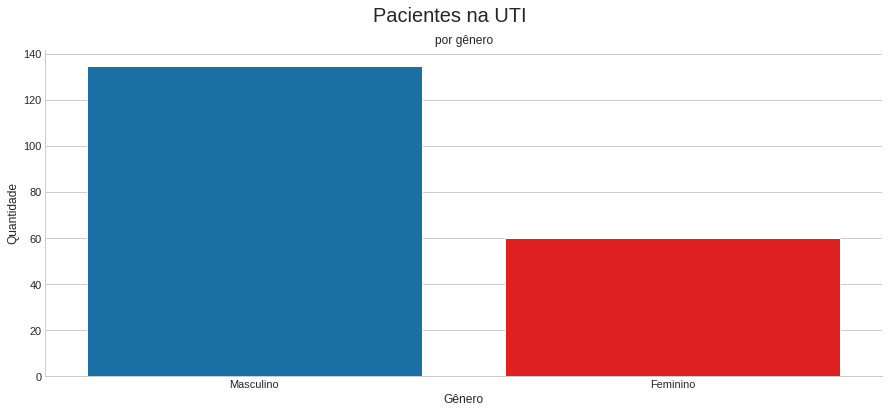

In [37]:
fig, ax = plt.subplots(figsize=(15,6))

sns.barplot(ax=ax, x=genero_uti['genero'], y=genero_uti['total'])
def_eixos(axs=ax, xlabel='Gênero', ylabel='Quantidade', title='por gênero', suptitle='Pacientes na UTI')

plt.show()

Dos 385 pacientes do Dataset, 195 foram para a UTI, destes 135 eram do sexo masculino e 60 do sexo feminino.

Agora, como é a distribuição por percentis dos pacientes que foram para a UTI?

In [ ]:
percentil_uti = pd.DataFrame(data_uti_positivo['AGE_PERCENTIL'].value_counts())
percentil_uti.rename(columns={'AGE_PERCENTIL':'total'}, inplace=True)

<IPython.core.display.Javascript object>

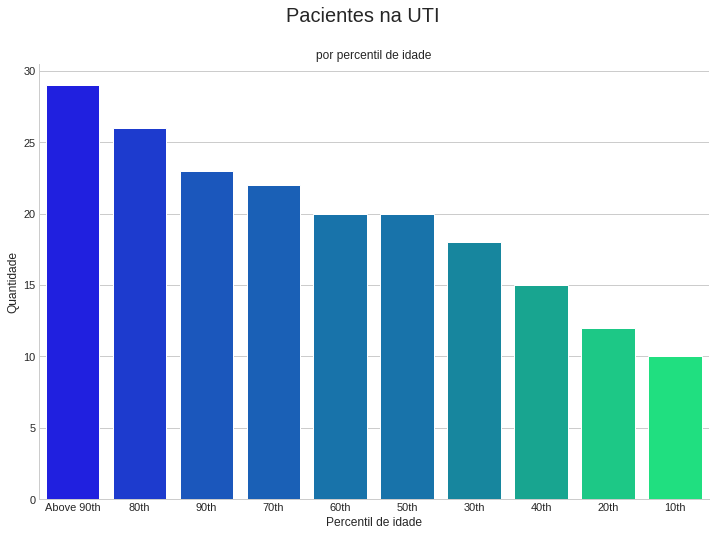

In [ ]:
fig, ax = plt.subplots()

palette = palette=mpl.cm.ScalarMappable(cmap='winter_r').to_rgba(percentil_uti['total'])
sns.barplot(ax=ax, x=percentil_uti.index, y=percentil_uti['total'], palette=palette)
def_eixos(axs=ax, xlabel='Percentil de idade', ylabel='Quantidade', title='por percentil de idade', suptitle='Pacientes na UTI')

plt.show()

Como já esperado a maioria dos pacientes que deram entrada na UTI tem mais de 90 e a absoluta maioria tem mais de 60 anos.

Observando a distribuição de pacientes acima de 65 que foram para a UTI:

In [48]:
above_65_positivo = pd.DataFrame([data_uti_positivo['AGE_ABOVE65'].value_counts()])

In [49]:
above_65_positivo = above_65_positivo.T

In [50]:
dict_labels = {1:'+65 anos',
               0: 'menor 65 anos'}
above_65_positivo.index = above_65_positivo.index.map(dict_labels)

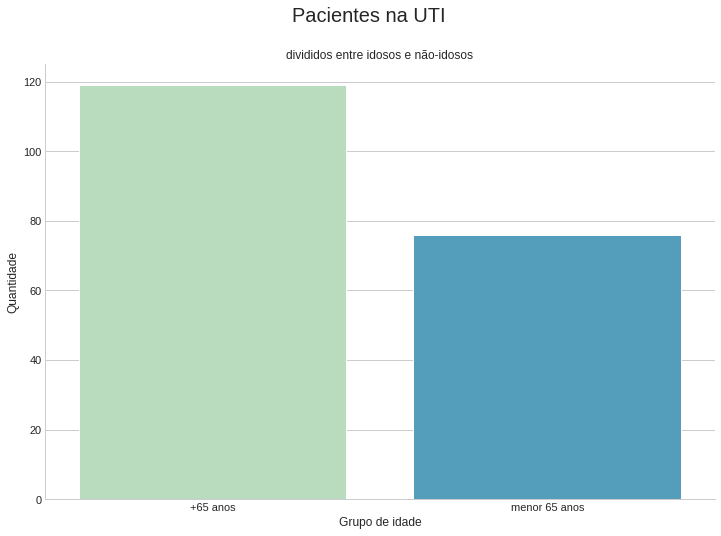

In [55]:
make_bar_plot(above_65_positivo, above_65_positivo.index, above_65_positivo['AGE_ABOVE65'], 'GnBu',
              xlabel='Grupo de idade', ylabel='Quantidade', title='divididos entre idosos e não-idosos', suptitle='Pacientes na UTI')

Como já podia-se ver no percentil de idade, pacientes com mais de 65 anos são a maioria na UTI, com 119 de 195 ou 61%. 

###Conclusões dos dados demográficos:

---
Nesta seção pudemos identificar a partir dos dados demográficos que dos 385 pacientes na base de dados, 195 foram para a UTI.

Destes, 135 eram do sexo masculino e 60 do sexo feminino, porém importante notarmos que o percentil com maior número de pacientes do sexo feminino é dos acima de 90 anos, a faixa de idade mais preocupante e afetada pela COVID-19.

Sobre os percentis pudemos observar que o maior número de pacientes que foram para a UTI tem mais de 65 anos e desses o que mais necessitou leitos de UTI foram os acima de 90 como já mencionamos, sua proporção ao longo do tempo e como são afetados pode ser visto [aqui](https://piaui.folha.uol.com.br/desde-o-comeco-do-ano-proporcao-de-idosos-nas-utis-de-covid-caiu-pela-metade-no-brasil/).

Um último ponto pertinente é que mais a frente, iremos transformar a coluna de percentis de valores categóricas para várias colunas binárias, garantindo a correta interpretação do modelo de Machine Learning.

##Observando os dados de Doenças prévias agrupadas

---
Nesta seção observaremos os dados das doenças prévias agrupadas, suas distribuições e o que estas podem nos informar sobre as relações com entrada ou não na UTI.


Identificamos que alguns pacientes a depender da janela tem 1 ou 0 em determinados grupos de doença, para evitar esses cruzamentos, iremos considerar apenas aqueles que apresentavam o determinado grupo de doença na primeira janela de 0-2 horas.

In [56]:
df_prev_disease = data.drop(data.iloc[:,1:4], axis=1)
df_prev_disease = df_prev_disease.query("WINDOW == '0-2'")
df_prev_disease = df_prev_disease.iloc[:,:10]
df_prev_disease.head(2)

PATIENT_VISIT_IDENTIFIER  DISEASE GROUPING 1  DISEASE GROUPING 2  \
0                         0                 0.0                 0.0   
5                         1                 0.0                 0.0   

   DISEASE GROUPING 3  DISEASE GROUPING 4  DISEASE GROUPING 5  \
0                 0.0                 0.0                 1.0   
5                 0.0                 0.0                 0.0   

   DISEASE GROUPING 6  HTN  IMMUNOCOMPROMISED  OTHER  
0                 1.0  0.0                0.0    1.0  
5                 0.0  1.0                1.0    1.0

Aqui é esperado que encontremos a maioria dos pacientes sem doenças prévias, visto que apesar de não termos acesso à qual tipo especificamente de doença é, os grupos parecem se referir a doenças crônicas.

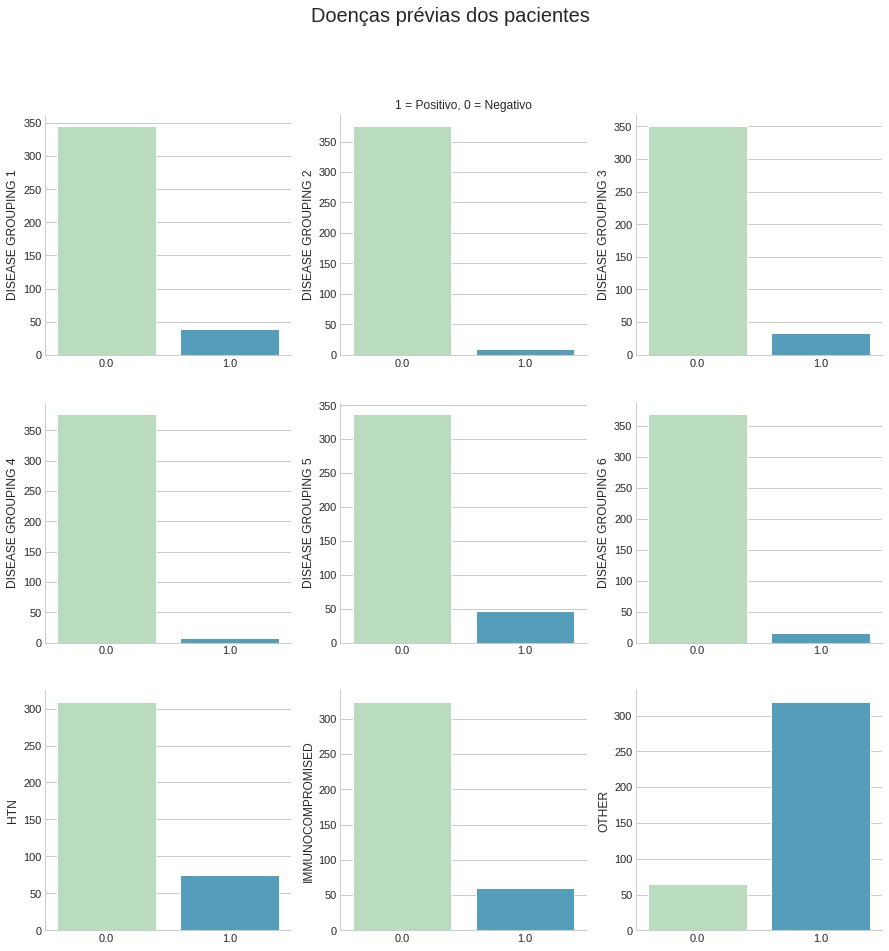

In [ ]:
make_df_value_counts(df_prev_disease['DISEASE GROUPING 1'], df_prev_disease['DISEASE GROUPING 2'],df_prev_disease['DISEASE GROUPING 3'],
                     df_prev_disease['DISEASE GROUPING 4'], df_prev_disease['DISEASE GROUPING 5'],df_prev_disease['DISEASE GROUPING 6'],
                     df_prev_disease['HTN'], df_prev_disease['IMMUNOCOMPROMISED'], df_prev_disease['OTHER'], 'GnBu',
                     'Doenças prévias dos pacientes')

Já havíamos antecipado, mas se confirmou que a maioria dos pacientes não tem doenças prévias com exceção do grupo 'Others' que pode representar uma miscelânia tão grande de doenças que acaba apresentando esse comportamento diferente.

##Observando os dados dos exames de sangue e sinais vitais

---
Nesta seção iremos observar os dados dos exames de sangue e os sinais vitais conjuntamente analisando sua distribuição e suas correlações.


In [ ]:
ex_sangue_data = data.drop(data.iloc[:,1:13], axis=1)
ex_sangue_data = ex_sangue_data.iloc[:,:-2]

In [ ]:
ex_sangue_data.head()

PATIENT_VISIT_IDENTIFIER  ALBUMIN_MEDIAN  ALBUMIN_MEAN  ALBUMIN_MIN  \
0                         0             NaN           NaN          NaN   
1                         0             NaN           NaN          NaN   
2                         0        0.605263      0.605263     0.605263   
3                         0             NaN           NaN          NaN   
4                         0        0.000000      0.000000     0.000000   

   ALBUMIN_MAX  ALBUMIN_DIFF  BE_ARTERIAL_MEDIAN  BE_ARTERIAL_MEAN  \
0          NaN           NaN                 NaN               NaN   
1          NaN           NaN                 NaN               NaN   
2     0.605263          -1.0           -1.000000         -1.000000   
3          NaN           NaN                 NaN               NaN   
4     0.000000          -1.0           -0.871658         -0.871658   

   BE_ARTERIAL_MIN  BE_ARTERIAL_MAX  BE_ARTERIAL_DIFF  BE_VENOUS_MEDIAN  \
0              NaN              NaN               NaN               NaN   
1              NaN              NaN               NaN               NaN   
2        -1.000000        -1.000000              -1.0         -1.000000   
3              NaN              NaN               NaN               NaN   
4        -0.871658        -0.871658              -1.0         -0.863874   

   BE_VENOUS_MEAN  BE_VENOUS_MIN  BE_VENOUS_MAX  BE_VENOUS_DIFF  \
0             NaN            NaN            NaN             NaN   
1             NaN            NaN            NaN             NaN   
2       -1.000000      -1.000000      -1.000000            -1.0   
3             NaN            NaN            NaN             NaN   
4       -0.863874      -0.863874      -0.863874            -1.0   

   BIC_ARTERIAL_MEDIAN  BIC_ARTERIAL_MEAN  BIC_ARTERIAL_MIN  BIC_ARTERIAL_MAX  \
0                  NaN                NaN               NaN               NaN   
1                  NaN                NaN               NaN               NaN   
2            -0.317073          -0.317073         -0.317073         -0.317073   
3                  NaN                NaN               NaN               NaN   
4            -0.317073          -0.317073         -0.317073         -0.317073   

   BIC_ARTERIAL_DIFF  BIC_VENOUS_MEDIAN  BIC_VENOUS_MEAN  BIC_VENOUS_MIN  \
0                NaN                NaN              NaN             NaN   
1                NaN                NaN              NaN             NaN   
2               -1.0          -0.317073        -0.317073       -0.317073   
3                NaN                NaN              NaN             NaN   
4               -1.0          -0.414634        -0.414634       -0.414634   

   BIC_VENOUS_MAX  BIC_VENOUS_DIFF  BILLIRUBIN_MEDIAN  BILLIRUBIN_MEAN  \
0             NaN              NaN                NaN              NaN   
1             NaN              NaN                NaN              NaN   
2       -0.317073             -1.0          -0.938950        -0.938950   
3             NaN              NaN                NaN              NaN   
4       -0.414634             -1.0          -0.979069        -0.979069   

   BILLIRUBIN_MIN  BILLIRUBIN_MAX  BILLIRUBIN_DIFF  BLAST_MEDIAN  BLAST_MEAN  \
0             NaN             NaN              NaN           NaN         NaN   
1             NaN             NaN              NaN           NaN         NaN   
2       -0.938950       -0.938950             -1.0          -1.0        -1.0   
3             NaN             NaN              NaN           NaN         NaN   
4       -0.979069       -0.979069             -1.0          -1.0        -1.0   

   BLAST_MIN  BLAST_MAX  BLAST_DIFF  CALCIUM_MEDIAN  CALCIUM_MEAN  \
0        NaN        NaN         NaN             NaN           NaN   
1        NaN        NaN         NaN             NaN           NaN   
2       -1.0       -1.0        -1.0        0.183673      0.183673   
3        NaN        NaN         NaN             NaN           NaN   
4       -1.0       -1.0        -1.0        0.326531      0.326531   

In [ ]:
ex_sangue_data.describe()

PATIENT_VISIT_IDENTIFIER  ALBUMIN_MEDIAN  ALBUMIN_MEAN  ALBUMIN_MIN  \
count               1925.000000      821.000000    821.000000   821.000000   
mean                 192.000000        0.528527      0.528527     0.528527   
std                  111.168431        0.224100      0.224100     0.224100   
min                    0.000000       -1.000000     -1.000000    -1.000000   
25%                   96.000000        0.605263      0.605263     0.605263   
50%                  192.000000        0.605263      0.605263     0.605263   
75%                  288.000000        0.605263      0.605263     0.605263   
max                  384.000000        1.000000      1.000000     1.000000   

       ALBUMIN_MAX  ALBUMIN_DIFF  BE_ARTERIAL_MEDIAN  BE_ARTERIAL_MEAN  \
count   821.000000         821.0          821.000000        821.000000   
mean      0.528527          -1.0           -0.963433         -0.963433   
std       0.224100           0.0            0.160870          0.160870   
min      -1.000000          -1.0           -1.000000         -1.000000   
25%       0.605263          -1.0           -1.000000         -1.000000   
50%       0.605263          -1.0           -1.000000         -1.000000   
75%       0.605263          -1.0           -1.000000         -1.000000   
max       1.000000          -1.0            1.000000          1.000000   

       BE_ARTERIAL_MIN  BE_ARTERIAL_MAX  BE_ARTERIAL_DIFF  BE_VENOUS_MEDIAN  \
count       821.000000       821.000000             821.0        821.000000   
mean         -0.963433        -0.963433              -1.0         -0.931121   
std           0.160870         0.160870               0.0          0.169509   
min          -1.000000        -1.000000              -1.0         -1.000000   
25%          -1.000000        -1.000000              -1.0         -1.000000   
50%          -1.000000        -1.000000              -1.0         -1.000000   
75%          -1.000000        -1.000000              -1.0         -0.958115   
max           1.000000         1.000000              -1.0          1.000000   

       BE_VENOUS_MEAN  BE_VENOUS_MIN  BE_VENOUS_MAX  BE_VENOUS_DIFF  \
count      821.000000     821.000000     821.000000           821.0   
mean        -0.931121      -0.931121      -0.931121            -1.0   
std          0.169509       0.169509       0.169509             0.0   
min         -1.000000      -1.000000      -1.000000            -1.0   
25%         -1.000000      -1.000000      -1.000000            -1.0   
50%         -1.000000      -1.000000      -1.000000            -1.0   
75%         -0.958115      -0.958115      -0.958115            -1.0   
max          1.000000       1.000000       1.000000            -1.0   

       BIC_ARTERIAL_MEDIAN  BIC_ARTERIAL_MEAN  BIC_ARTERIAL_MIN  \
count           821.000000         821.000000        821.000000   
mean             -0.310924          -0.310924         -0.310924   
std               0.100256           0.100256          0.100256   
min              -1.000000          -1.000000         -1.000000   
25%              -0.317073          -0.317073         -0.317073   
50%              -0.317073          -0.317073         -0.317073   
75%              -0.317073          -0.317073         -0.317073   
max               1.000000           1.000000          1.000000   

       BIC_ARTERIAL_MAX  BIC_ARTERIAL_DIFF  BIC_VENOUS_MEDIAN  \
count        821.000000              821.0         821.000000   
mean          -0.310924               -1.0          -0.311845   
std            0.100256                0.0           0.118812   
min           -1.000000               -1.0          -1.000000   
25%           -0.317073               -1.0          -0.317073   
50%           -0.317073               -1.0          -0.317073   
75%           -0.317073               -1.0          -0.317073   
max            1.000000               -1.0           1.000000   

       BIC_VENOUS_MEAN  BIC_VENOUS_MIN  BIC_VENOUS_MAX  BIC_VENOUS_DIFF  \
count       821.0000

Uma primeira observação é que nessas colunas temos dados em branco representados por NaN (*Not a Number* em inglês) e que necessitarão de tratamento para preenche-los.

In [ ]:
ex_sangue_data.isna().sum()

PATIENT_VISIT_IDENTIFIER              0
ALBUMIN_MEDIAN                     1104
ALBUMIN_MEAN                       1104
ALBUMIN_MIN                        1104
ALBUMIN_MAX                        1104
                                   ... 
BLOODPRESSURE_SISTOLIC_DIFF_REL     685
HEART_RATE_DIFF_REL                 685
RESPIRATORY_RATE_DIFF_REL           748
TEMPERATURE_DIFF_REL                694
OXYGEN_SATURATION_DIFF_REL          686
Length: 217, dtype: int64

A maioria dos dados de exame de sangue estão vazios.

Há uma explicação para isso: Não faz sentido ficar realizando exames de sangue nos pacientes de duas em duas horas (diferença entre as janelas). Na média esses valores não variam tanto.

Com essa ideia da pouca variação no tempo, iremos utilizar uma função para preencher esses dados e já deixá-los preparados para a aplicação de Machine Learning mais à frente, pensando em que os modelos não lidam bem com dados nulos e podem gerar distorções na previsão do modelo.

In [ ]:
#Aqui faremos as alterações diretamente no dataframe principal 'data'
data = preenche_tabela(data)

É comum que para alguns modelos de aprendizado supervisionado de máquina tenhamos que fazer uma limpeza nos dados retirando as *features* que tem alta correlação entre si, para evitar alta variância e depreciação na capacidade de predição do modelo.

Antevendo isso, iremos plotar a correlação das colunas dos exames de sangue e dos sinais vitais, que podemos olhar acima, devido ao preenchimento acabaram muitas sendo iguais.

In [ ]:
data.iloc[:,13:-2].corr()

ALBUMIN_MEDIAN  ALBUMIN_MEAN  ALBUMIN_MIN  \
ALBUMIN_MEDIAN                         1.000000      1.000000     1.000000   
ALBUMIN_MEAN                           1.000000      1.000000     1.000000   
ALBUMIN_MIN                            1.000000      1.000000     1.000000   
ALBUMIN_MAX                            1.000000      1.000000     1.000000   
ALBUMIN_DIFF                                NaN           NaN          NaN   
...                                         ...           ...          ...   
BLOODPRESSURE_SISTOLIC_DIFF_REL       -0.192304     -0.192304    -0.192304   
HEART_RATE_DIFF_REL                   -0.158783     -0.158783    -0.158783   
RESPIRATORY_RATE_DIFF_REL             -0.223759     -0.223759    -0.223759   
TEMPERATURE_DIFF_REL                  -0.168343     -0.168343    -0.168343   
OXYGEN_SATURATION_DIFF_REL            -0.176259     -0.176259    -0.176259   

                                 ALBUMIN_MAX  ALBUMIN_DIFF  \
ALBUMIN_MEDIAN                      1.000000           NaN   
ALBUMIN_MEAN                        1.000000           NaN   
ALBUMIN_MIN                         1.000000           NaN   
ALBUMIN_MAX                         1.000000           NaN   
ALBUMIN_DIFF                             NaN           NaN   
...                                      ...           ...   
BLOODPRESSURE_SISTOLIC_DIFF_REL    -0.192304           NaN   
HEART_RATE_DIFF_REL                -0.158783           NaN   
RESPIRATORY_RATE_DIFF_REL          -0.223759           NaN   
TEMPERATURE_DIFF_REL               -0.168343           NaN   
OXYGEN_SATURATION_DIFF_REL         -0.176259           NaN   

                                 BE_ARTERIAL_MEDIAN  BE_ARTERIAL_MEAN  \
ALBUMIN_MEDIAN                            -0.186628         -0.186628   
ALBUMIN_MEAN                              -0.186628         -0.186628   
ALBUMIN_MIN                               -0.186628         -0.186628   
ALBUMIN_MAX                               -0.186628         -0.186628   
ALBUMIN_DIFF                                    NaN               NaN   
...                                             ...               ...   
BLOODPRESSURE_SISTOLIC_DIFF_REL            0.248154          0.248154   
HEART_RATE_DIFF_REL                        0.172674          0.172674   
RESPIRATORY_RATE_DIFF_REL                  0.240681          0.240681   
TEMPERATURE_DIFF_REL                       0.183050          0.183050   
OXYGEN_SATURATION_DIFF_REL                 0.206959          0.206959   

                                 BE_ARTERIAL_MIN  BE_ARTERIAL_MAX  \
ALBUMIN_MEDIAN                         -0.186628        -0.186628   
ALBUMIN_MEAN                           -0.186628        -0.186628   
ALBUMIN_MIN                            -0.186628        -0.186628   
ALBUMIN_MAX                            -0.186628        -0.186628   
ALBUMIN_DIFF                                 NaN              NaN   
...                                          ...              ...   
BLOODPRESSURE_SISTOLIC_DIFF_REL         0.248154         0.248154   
HEART_RATE_DIFF_REL                     0.172674         0.172674   
RESPIRATORY_RATE_DIFF_REL               0.240681         0.240681   
TEMPERATURE_DIFF_REL                    0.183050         0.183050   
OXYGEN_SATURATION_DIFF_REL              0.206959         0.206959   

                                 BE_ARTERIAL_DIFF  BE_VENOUS_MEDIAN  \
ALBUMIN_MEDIAN                                NaN         -0.147306   
ALBUMIN_MEAN                                  NaN         -0.147306   
ALBUMIN_MIN                                   NaN         -0.147306   
ALBUMIN_MAX                                   NaN         -0.147306   
ALBUMIN_DIFF                                  NaN               NaN   
...                                           ...               ...   
BLOODPRESSURE_SISTOLIC_DIFF_REL               NaN          0.178412   
HEART_RATE_DIFF_REL                           NaN          0.144498   
RESPIR

#Seção 3: Feature Engineering e Feature Selection

Seguindo o desafio da equipe do Sírio-libânes e também sua recomendação, excluiremos do dataframe os pacientes que deram entrada logo na primeira janela por não termos como saber se os dados registrados para eles foram feitos antes ou depois da entrada na UTI.

Em seguida prepararemos os dados trazendo a entrada ou não na UTI para a primeira janela (0-2 horas). 
A lógica por trás da escolha é a seguinte: quanto mais cedo prevermos a entrada na UTI melhor para a saúde e as chances de sobrevivência do paciente e para a organização do hospital sobre a necessidade dos leitos de UTI.

Decidimos por uma abordagem de selecionar três dataframes com características diferentes entre si para trabalharmos as aplicações dos modelos mais a frente.

In [ ]:
#excluindo pacientes que foram para a UTI na primeira janela
data = limpa_dados(data)
data

PATIENT_VISIT_IDENTIFIER  AGE_ABOVE65 AGE_PERCENTIL  GENDER  \
0                            0            1          60th       0   
1                            0            1          60th       0   
2                            0            1          60th       0   
3                            0            1          60th       0   
4                            0            1          60th       0   
...                        ...          ...           ...     ...   
1920                       384            0          50th       1   
1921                       384            0          50th       1   
1922                       384            0          50th       1   
1923                       384            0          50th       1   
1924                       384            0          50th       1   

      DISEASE GROUPING 1  DISEASE GROUPING 2  DISEASE GROUPING 3  \
0                    0.0                 0.0                 0.0   
1                    0.0                 0.0                 0.0   
2                    0.0                 0.0                 0.0   
3                    0.0                 0.0                 0.0   
4                    0.0                 0.0                 0.0   
...                  ...                 ...                 ...   
1920                 0.0                 0.0                 0.0   
1921                 0.0                 0.0                 0.0   
1922                 0.0                 0.0                 0.0   
1923                 0.0                 0.0                 0.0   
1924                 0.0                 0.0                 1.0   

      DISEASE GROUPING 4  DISEASE GROUPING 5  DISEASE GROUPING 6  HTN  \
0                    0.0                 1.0                 1.0  0.0   
1                    0.0                 1.0                 1.0  0.0   
2                    0.0                 1.0                 1.0  0.0   
3                    0.0                 1.0                 1.0  0.0   
4                    0.0                 1.0                 1.0  0.0   
...                  ...                 ...                 ...  ...   
1920                 0.0                 0.0                 0.0  0.0   
1921                 0.0                 0.0                 0.0  0.0   
1922                 0.0                 0.0                 0.0  0.0   
1923                 0.0                 0.0                 0.0  0.0   
1924                 0.0                 0.0                 0.0  0.0   

      IMMUNOCOMPROMISED  OTHER  ALBUMIN_MEDIAN  ALBUMIN_MEAN  ALBUMIN_MIN  \
0                   0.0    1.0        0.605263      0.605263     0.605263   
1                   0.0    1.0        0.605263      0.605263     0.605263   
2                   0.0    1.0        0.605263      0.605263     0.605263   
3                   0.0    1.0        0.000000      0.000000     0.000000   
4                   0.0    1.0        0.000000      0.000000     0.000000   
...                 ...    ...             ...           ...          ...   
1920                0.0    1.0        0.605263      0.605263     0.605263   
1921                0.0    1.0        0.605263      0.605263     0.605263   
1922                0.0    1.0        0.605263      0.605263     0.605263   
1923                0.0    1.0        0.605263      0.605263     0.605263   
1924                0.0    1.0        0.605263      0.605263     0.605263   

      ALBUMIN_MAX  ALBUMIN_DIFF  BE_ARTERIAL_MEDIAN  BE_ARTERIAL_MEAN  \
0        0.605263          -1.0           -1.000000         -1.000000   
1        0.605263          -1.0           -1.000000         -1.000000   
2        0.605263          -1.0           -1.000000         -1.000000   
3        0.000000          -1.0           -0.871658         -0.871658   
4        0.000000          -1.0           -0.871658         -0.871658   
...           ...           ...                 ...               ...   
1920     0.605263          -1.0           -1.00

In [ ]:
#preparando o dataframe para a janela 0-2
data_clean = data.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 352 entries, (0, 0) to (384, 1920)
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 652.2+ KB


In [ ]:
data_clean

PATIENT_VISIT_IDENTIFIER  AGE_ABOVE65  \
PATIENT_VISIT_IDENTIFIER                                               
0                        0                            0            1   
2                        10                           2            0   
3                        15                           3            0   
4                        20                           4            0   
5                        25                           5            0   
...                                                 ...          ...   
380                      1900                       380            0   
381                      1905                       381            1   
382                      1910                       382            0   
383                      1915                       383            0   
384                      1920                       384            0   

                              AGE_PERCENTIL  GENDER  DISEASE GROUPING 1  \
PATIENT_VISIT_IDENTIFIER                                                  
0                        0             60th       0                 0.0   
2                        10            10th       0                 0.0   
3                        15            40th       1                 0.0   
4                        20            10th       0                 0.0   
5                        25            10th       0                 0.0   
...                                     ...     ...                 ...   
380                      1900          40th       1                 0.0   
381                      1905    Above 90th       0                 0.0   
382                      1910          50th       0                 0.0   
383                      1915          40th       1                 0.0   
384                      1920          50th       1                 0.0   

                               DISEASE GROUPING 2  DISEASE GROUPING 3  \
PATIENT_VISIT_IDENTIFIER                                                
0                        0                    0.0                 0.0   
2                        10                   0.0                 0.0   
3                        15                   0.0                 0.0   
4                        20                   0.0                 0.0   
5                        25                   0.0                 0.0   
...                                           ...                 ...   
380                      1900                 0.0                 0.0   
381                      1905                 0.0                 0.0   
382                      1910                 0.0                 0.0   
383                      1915                 0.0                 0.0   
384                      1920                 0.0                 0.0   

                               DISEASE GROUPING 4  DISEASE GROUPING 5  \
PATIENT_VISIT_IDENTIFIER                                                
0                        0                    0.0                 1.0   
2                        10                   0.0                 0.0   
3                        15                   0.0                 0.0   
4                        20                   0.0                 0.0   
5                        25                   0.0                 0.0   
...                                           ...                 ...   
380                      1900                 0.0                 0.0   
381                      1905                 0.0                 0.0   
382                      1910                 0.0                 0.0   
383                      1915                 0.0                 0.0   
384                      1920                 0.0                 0.0   

                               DISEASE GROUPING 6  HTN  IMMUNOCOMPROMISED  \
PATIENT_VISIT_IDENTIFIER                                                    
0                        0                    1.0  0.0          

Agora podemos dropar as colunas que não tem mais uso ou pertinência no dataframe: window e o identificador do paciente.

In [ ]:
data_clean = data_clean.drop(columns=['PATIENT_VISIT_IDENTIFIER', 'WINDOW'])

Dataframe preparado vamos à parte de transformar a coluna age_percentil como já citamos antes.

Aqui faremos dois dataframes e iremos rodar as primeiras seleções de modelo com eles, um com a coluna como classes e outra criando dummy variables ou variáveis binárias para cada classe da coluna e iremos ver a qual nossos modelos respondem melhor.

In [ ]:
#transformando em variáveis binárias
data_clean_binary = pd.get_dummies(data_clean, columns=['AGE_PERCENTIL'])
icu = data_clean_binary['ICU']
data_clean_binary = data_clean_binary.drop(columns=['ICU'])
data_clean_binary['ICU'] = icu 
data_clean_binary

AGE_ABOVE65  GENDER  DISEASE GROUPING 1  \
PATIENT_VISIT_IDENTIFIER                                                 
0                        0               1       0                 0.0   
2                        10              0       0                 0.0   
3                        15              0       1                 0.0   
4                        20              0       0                 0.0   
5                        25              0       0                 0.0   
...                                    ...     ...                 ...   
380                      1900            0       1                 0.0   
381                      1905            1       0                 0.0   
382                      1910            0       0                 0.0   
383                      1915            0       1                 0.0   
384                      1920            0       1                 0.0   

                               DISEASE GROUPING 2  DISEASE GROUPING 3  \
PATIENT_VISIT_IDENTIFIER                                                
0                        0                    0.0                 0.0   
2                        10                   0.0                 0.0   
3                        15                   0.0                 0.0   
4                        20                   0.0                 0.0   
5                        25                   0.0                 0.0   
...                                           ...                 ...   
380                      1900                 0.0                 0.0   
381                      1905                 0.0                 0.0   
382                      1910                 0.0                 0.0   
383                      1915                 0.0                 0.0   
384                      1920                 0.0                 0.0   

                               DISEASE GROUPING 4  DISEASE GROUPING 5  \
PATIENT_VISIT_IDENTIFIER                                                
0                        0                    0.0                 1.0   
2                        10                   0.0                 0.0   
3                        15                   0.0                 0.0   
4                        20                   0.0                 0.0   
5                        25                   0.0                 0.0   
...                                           ...                 ...   
380                      1900                 0.0                 0.0   
381                      1905                 0.0                 0.0   
382                      1910                 0.0                 0.0   
383                      1915                 0.0                 0.0   
384                      1920                 0.0                 0.0   

                               DISEASE GROUPING 6  HTN  IMMUNOCOMPROMISED  \
PATIENT_VISIT_IDENTIFIER                                                    
0                        0                    1.0  0.0                0.0   
2                        10                   0.0  0.0                0.0   
3                        15                   0.0  0.0                1.0   
4                        20                   0.0  0.0                0.0   
5                        25                   0.0  0.0                0.0   
...                                           ...  ...                ...   
380                      1900                 0.0  0.0                1.0   
381                      1905                 0.0  0.0                1.0   
382                      1910                 0.0  0.0                0.0   
383                      1915                 0.0  0.0                0.0   
384                      1920                 0.0  0.0                0.0   

                               OTHER  ALBUMIN_MEDIAN  ALBUMIN_MEAN  \
PATIENT_VISIT_IDENTIFIER                                             
0                        0

In [ ]:
#transformando em classes
labelencoder = LabelEncoder()
data_clean_class = data_clean.copy()
data_clean_class['AGE_PERCENTIL'] = labelencoder.fit_transform(data_clean_class.AGE_PERCENTIL)
data_clean_class

<IPython.core.display.Javascript object>

AGE_ABOVE65  AGE_PERCENTIL  GENDER  \
PATIENT_VISIT_IDENTIFIER                                            
0                        0               1              5       0   
2                        10              0              0       0   
3                        15              0              3       1   
4                        20              0              0       0   
5                        25              0              0       0   
...                                    ...            ...     ...   
380                      1900            0              3       1   
381                      1905            1              9       0   
382                      1910            0              4       0   
383                      1915            0              3       1   
384                      1920            0              4       1   

                               DISEASE GROUPING 1  DISEASE GROUPING 2  \
PATIENT_VISIT_IDENTIFIER                                                
0                        0                    0.0                 0.0   
2                        10                   0.0                 0.0   
3                        15                   0.0                 0.0   
4                        20                   0.0                 0.0   
5                        25                   0.0                 0.0   
...                                           ...                 ...   
380                      1900                 0.0                 0.0   
381                      1905                 0.0                 0.0   
382                      1910                 0.0                 0.0   
383                      1915                 0.0                 0.0   
384                      1920                 0.0                 0.0   

                               DISEASE GROUPING 3  DISEASE GROUPING 4  \
PATIENT_VISIT_IDENTIFIER                                                
0                        0                    0.0                 0.0   
2                        10                   0.0                 0.0   
3                        15                   0.0                 0.0   
4                        20                   0.0                 0.0   
5                        25                   0.0                 0.0   
...                                           ...                 ...   
380                      1900                 0.0                 0.0   
381                      1905                 0.0                 0.0   
382                      1910                 0.0                 0.0   
383                      1915                 0.0                 0.0   
384                      1920                 0.0                 0.0   

                               DISEASE GROUPING 5  DISEASE GROUPING 6  HTN  \
PATIENT_VISIT_IDENTIFIER                                                     
0                        0                    1.0                 1.0  0.0   
2                        10                   0.0                 0.0  0.0   
3                        15                   0.0                 0.0  0.0   
4                        20                   0.0                 0.0  0.0   
5                        25                   0.0                 0.0  0.0   
...                                           ...                 ...  ...   
380                      1900                 0.0                 0.0  0.0   
381                      1905                 0.0                 0.0  0.0   
382                      1910                 0.0                 0.0  0.0   
383                      1915                 0.0                 0.0  0.0   
384                      1920                 0.0                 0.0  0.0   

                               IMMUNOCOMPROMISED  OTHER  ALBUMIN_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                                  
0                        0                   0.0    1.0        0.605

In [ ]:
pd.DataFrame(data_clean['ICU'].value_counts())

ICU
0  189
1  163

Agora que preparamos e limpamos nossos dados vamos realizar uma primeira feature selection utilizando alguns métodos tradicionais.

O primeiro vai ser utilizando o SelectKbest, como estamos diante de um problema de classificação 1 - foi para UTI e 0 - Não foi para UTI, utilizaremos o parâmetro f_classif do SelectKBest.

In [ ]:
#60 colunas ou 25% colunas com mais correlação com o target (ICU) no dataframe de colunas binárias
x = data_clean_binary.drop(columns=['ICU'])
y = data_clean_binary['ICU']
f_classif1 = SelectKBest(score_func=f_classif, k=60)
fit1 = f_classif1.fit(x,y)
cols = fit1.get_support(indices=True)
data_clean_binary.iloc[:,cols]

AGE_ABOVE65  HTN  CALCIUM_MEDIAN  CALCIUM_MEAN  \
PATIENT_VISIT_IDENTIFIER                                                        
0                        0               1  0.0        0.183673      0.183673   
2                        10              0  0.0        0.357143      0.357143   
3                        15              0  0.0        0.326531      0.326531   
4                        20              0  0.0        0.357143      0.357143   
5                        25              0  0.0        0.357143      0.357143   
...                                    ...  ...             ...           ...   
380                      1900            0  0.0        0.326531      0.326531   
381                      1905            1  0.0        0.285714      0.285714   
382                      1910            0  0.0        0.357143      0.357143   
383                      1915            0  0.0        0.357143      0.357143   
384                      1920            0  0.0        0.244898      0.244898   

                               CALCIUM_MIN  CALCIUM_MAX  CREATININ_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                                    
0                        0        0.183673     0.183673         -0.868365   
2                        10       0.357143     0.357143         -0.912243   
3                        15       0.326531     0.326531         -0.968861   
4                        20       0.357143     0.357143         -0.913659   
5                        25       0.357143     0.357143         -0.891012   
...                                    ...          ...               ...   
380                      1900     0.326531     0.326531         -0.937721   
381                      1905     0.285714     0.285714         -0.886766   
382                      1910     0.357143     0.357143         -0.905166   
383                      1915     0.357143     0.357143         -0.922151   
384                      1920     0.244898     0.244898         -0.934890   

                               CREATININ_MEAN  CREATININ_MIN  CREATININ_MAX  \
PATIENT_VISIT_IDENTIFIER                                                      
0                        0          -0.868365      -0.868365      -0.868365   
2                        10         -0.912243      -0.912243      -0.912243   
3                        15         -0.968861      -0.968861      -0.968861   
4                        20         -0.913659      -0.913659      -0.913659   
5                        25         -0.891012      -0.891012      -0.891012   
...                                       ...            ...            ...   
380                      1900       -0.937721      -0.937721      -0.937721   
381                      1905       -0.886766      -0.886766      -0.886766   
382                      1910       -0.905166      -0.905166      -0.905166   
383                      1915       -0.922151      -0.922151      -0.922151   
384                      1920       -0.934890      -0.934890      -0.934890   

                               GLUCOSE_MEDIAN  GLUCOSE_MEAN  GLUCOSE_MIN  \
PATIENT_VISIT_IDENTIFIER                                                   
0                        0          -0.891993     -0.891993    -0.891993   
2                        10         -0.780261     -0.780261    -0.780261   
3                        15         -0.891993     -0.891993    -0.891993   
4                        20         -0.851024     -0.851024    -0.851024   
5                        25         -0.891993     -0.891993    -0.891993   
...                                       ...           ...          ...   
380                      1900       -0.824953     -0.824953    -0.824953   
381                      1905       -0.891993     -0.891993    -0.891993   
382                      1910       -0.891993     -0.891993    -0.891993   
383                      1915       -0.843575     -0.843575    -0.843575   
384                      1920      

In [ ]:
data_clean_binary_selected = data_clean_binary.iloc[:,cols]
data_clean_binary_selected['ICU'] = y
data_clean_binary_selected

AGE_ABOVE65  HTN  CALCIUM_MEDIAN  CALCIUM_MEAN  \
PATIENT_VISIT_IDENTIFIER                                                        
0                        0               1  0.0        0.183673      0.183673   
2                        10              0  0.0        0.357143      0.357143   
3                        15              0  0.0        0.326531      0.326531   
4                        20              0  0.0        0.357143      0.357143   
5                        25              0  0.0        0.357143      0.357143   
...                                    ...  ...             ...           ...   
380                      1900            0  0.0        0.326531      0.326531   
381                      1905            1  0.0        0.285714      0.285714   
382                      1910            0  0.0        0.357143      0.357143   
383                      1915            0  0.0        0.357143      0.357143   
384                      1920            0  0.0        0.244898      0.244898   

                               CALCIUM_MIN  CALCIUM_MAX  CREATININ_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                                    
0                        0        0.183673     0.183673         -0.868365   
2                        10       0.357143     0.357143         -0.912243   
3                        15       0.326531     0.326531         -0.968861   
4                        20       0.357143     0.357143         -0.913659   
5                        25       0.357143     0.357143         -0.891012   
...                                    ...          ...               ...   
380                      1900     0.326531     0.326531         -0.937721   
381                      1905     0.285714     0.285714         -0.886766   
382                      1910     0.357143     0.357143         -0.905166   
383                      1915     0.357143     0.357143         -0.922151   
384                      1920     0.244898     0.244898         -0.934890   

                               CREATININ_MEAN  CREATININ_MIN  CREATININ_MAX  \
PATIENT_VISIT_IDENTIFIER                                                      
0                        0          -0.868365      -0.868365      -0.868365   
2                        10         -0.912243      -0.912243      -0.912243   
3                        15         -0.968861      -0.968861      -0.968861   
4                        20         -0.913659      -0.913659      -0.913659   
5                        25         -0.891012      -0.891012      -0.891012   
...                                       ...            ...            ...   
380                      1900       -0.937721      -0.937721      -0.937721   
381                      1905       -0.886766      -0.886766      -0.886766   
382                      1910       -0.905166      -0.905166      -0.905166   
383                      1915       -0.922151      -0.922151      -0.922151   
384                      1920       -0.934890      -0.934890      -0.934890   

                               GLUCOSE_MEDIAN  GLUCOSE_MEAN  GLUCOSE_MIN  \
PATIENT_VISIT_IDENTIFIER                                                   
0                        0          -0.891993     -0.891993    -0.891993   
2                        10         -0.780261     -0.780261    -0.780261   
3                        15         -0.891993     -0.891993    -0.891993   
4                        20         -0.851024     -0.851024    -0.851024   
5                        25         -0.891993     -0.891993    -0.891993   
...                                       ...           ...          ...   
380                      1900       -0.824953     -0.824953    -0.824953   
381                      1905       -0.891993     -0.891993    -0.891993   
382                      1910       -0.891993     -0.891993    -0.891993   
383                      1915       -0.843575     -0.843575    -0.843575   
384                      1920      

In [ ]:
#60 colunas ou 25% colunas com mais correlação com o target (ICU) no dataframe de age_percentil por classes
x2 = data_clean_class.drop(columns=['ICU'])
y2 = data_clean_class['ICU']
f_classif2 = SelectKBest(score_func=f_classif, k=60)
fit2 = f_classif2.fit(x2,y2)
cols2 = fit2.get_support(indices=True)
data_clean_class.iloc[:,cols2]

AGE_ABOVE65  AGE_PERCENTIL  HTN  \
PATIENT_VISIT_IDENTIFIER                                         
0                        0               1              5  0.0   
2                        10              0              0  0.0   
3                        15              0              3  0.0   
4                        20              0              0  0.0   
5                        25              0              0  0.0   
...                                    ...            ...  ...   
380                      1900            0              3  0.0   
381                      1905            1              9  0.0   
382                      1910            0              4  0.0   
383                      1915            0              3  0.0   
384                      1920            0              4  0.0   

                               CALCIUM_MEDIAN  CALCIUM_MEAN  CALCIUM_MIN  \
PATIENT_VISIT_IDENTIFIER                                                   
0                        0           0.183673      0.183673     0.183673   
2                        10          0.357143      0.357143     0.357143   
3                        15          0.326531      0.326531     0.326531   
4                        20          0.357143      0.357143     0.357143   
5                        25          0.357143      0.357143     0.357143   
...                                       ...           ...          ...   
380                      1900        0.326531      0.326531     0.326531   
381                      1905        0.285714      0.285714     0.285714   
382                      1910        0.357143      0.357143     0.357143   
383                      1915        0.357143      0.357143     0.357143   
384                      1920        0.244898      0.244898     0.244898   

                               CALCIUM_MAX  CREATININ_MEDIAN  CREATININ_MEAN  \
PATIENT_VISIT_IDENTIFIER                                                       
0                        0        0.183673         -0.868365       -0.868365   
2                        10       0.357143         -0.912243       -0.912243   
3                        15       0.326531         -0.968861       -0.968861   
4                        20       0.357143         -0.913659       -0.913659   
5                        25       0.357143         -0.891012       -0.891012   
...                                    ...               ...             ...   
380                      1900     0.326531         -0.937721       -0.937721   
381                      1905     0.285714         -0.886766       -0.886766   
382                      1910     0.357143         -0.905166       -0.905166   
383                      1915     0.357143         -0.922151       -0.922151   
384                      1920     0.244898         -0.934890       -0.934890   

                               CREATININ_MIN  CREATININ_MAX  GLUCOSE_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                                      
0                        0         -0.868365      -0.868365       -0.891993   
2                        10        -0.912243      -0.912243       -0.780261   
3                        15        -0.968861      -0.968861       -0.891993   
4                        20        -0.913659      -0.913659       -0.851024   
5                        25        -0.891012      -0.891012       -0.891993   
...                                      ...            ...             ...   
380                      1900      -0.937721      -0.937721       -0.824953   
381                      1905      -0.886766      -0.886766       -0.891993   
382                      1910      -0.905166      -0.905166       -0.891993   
383                      1915      -0.922151      -0.922151       -0.843575   
384                      1920      -0.934890      -0.934890       -0.862197   

                               GLUCOSE_MEAN  GLUCOSE_MIN  GLUCOSE_MAX  \
PATIENT_VISIT_IDENTIFIER                 

In [ ]:
data_clean_class_selected = data_clean_class.iloc[:,cols2]
data_clean_class_selected['ICU'] = y2
data_clean_class_selected

AGE_ABOVE65  AGE_PERCENTIL  HTN  \
PATIENT_VISIT_IDENTIFIER                                         
0                        0               1              5  0.0   
2                        10              0              0  0.0   
3                        15              0              3  0.0   
4                        20              0              0  0.0   
5                        25              0              0  0.0   
...                                    ...            ...  ...   
380                      1900            0              3  0.0   
381                      1905            1              9  0.0   
382                      1910            0              4  0.0   
383                      1915            0              3  0.0   
384                      1920            0              4  0.0   

                               CALCIUM_MEDIAN  CALCIUM_MEAN  CALCIUM_MIN  \
PATIENT_VISIT_IDENTIFIER                                                   
0                        0           0.183673      0.183673     0.183673   
2                        10          0.357143      0.357143     0.357143   
3                        15          0.326531      0.326531     0.326531   
4                        20          0.357143      0.357143     0.357143   
5                        25          0.357143      0.357143     0.357143   
...                                       ...           ...          ...   
380                      1900        0.326531      0.326531     0.326531   
381                      1905        0.285714      0.285714     0.285714   
382                      1910        0.357143      0.357143     0.357143   
383                      1915        0.357143      0.357143     0.357143   
384                      1920        0.244898      0.244898     0.244898   

                               CALCIUM_MAX  CREATININ_MEDIAN  CREATININ_MEAN  \
PATIENT_VISIT_IDENTIFIER                                                       
0                        0        0.183673         -0.868365       -0.868365   
2                        10       0.357143         -0.912243       -0.912243   
3                        15       0.326531         -0.968861       -0.968861   
4                        20       0.357143         -0.913659       -0.913659   
5                        25       0.357143         -0.891012       -0.891012   
...                                    ...               ...             ...   
380                      1900     0.326531         -0.937721       -0.937721   
381                      1905     0.285714         -0.886766       -0.886766   
382                      1910     0.357143         -0.905166       -0.905166   
383                      1915     0.357143         -0.922151       -0.922151   
384                      1920     0.244898         -0.934890       -0.934890   

                               CREATININ_MIN  CREATININ_MAX  GLUCOSE_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                                      
0                        0         -0.868365      -0.868365       -0.891993   
2                        10        -0.912243      -0.912243       -0.780261   
3                        15        -0.968861      -0.968861       -0.891993   
4                        20        -0.913659      -0.913659       -0.851024   
5                        25        -0.891012      -0.891012       -0.891993   
...                                      ...            ...             ...   
380                      1900      -0.937721      -0.937721       -0.824953   
381                      1905      -0.886766      -0.886766       -0.891993   
382                      1910      -0.905166      -0.905166       -0.891993   
383                      1915      -0.922151      -0.922151       -0.843575   
384                      1920      -0.934890      -0.934890       -0.862197   

                               GLUCOSE_MEAN  GLUCOSE_MIN  GLUCOSE_MAX  \
PATIENT_VISIT_IDENTIFIER                 

In [ ]:
pd.Series(cols==cols2).value_counts()

False    32
True     28
dtype: int64

Podemos verificar uma diferença de apenas 4 colunas entre os dataframe, duas sabemos que são as classes binárias do age_percentil. O que nos mostra um bom consenso sobre as features mais correlacionadas com o target.

Como discutimos na seção de análise dos exames de sangue, é importante nos modelos de classificação evitar as colunas altamente correlacionadas, portanto, após a seleção do 25% de colunas mais correlacionadas, iremos agora retirar as altamente correlacionas entre si.

In [ ]:
corr_matrix = data_clean_binary_selected.iloc[:,1:-3].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column]>0.9)]
data_clean_binary_selected = data_clean_binary_selected.drop(columns=to_drop)
data_clean_binary_selected

AGE_ABOVE65  HTN  CALCIUM_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                          
0                        0               1  0.0        0.183673   
2                        10              0  0.0        0.357143   
3                        15              0  0.0        0.326531   
4                        20              0  0.0        0.357143   
5                        25              0  0.0        0.357143   
...                                    ...  ...             ...   
380                      1900            0  0.0        0.326531   
381                      1905            1  0.0        0.285714   
382                      1910            0  0.0        0.357143   
383                      1915            0  0.0        0.357143   
384                      1920            0  0.0        0.244898   

                               CREATININ_MEDIAN  GLUCOSE_MEDIAN  INR_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                                      
0                        0            -0.868365       -0.891993   -0.932246   
2                        10           -0.912243       -0.780261   -0.959849   
3                        15           -0.968861       -0.891993   -0.959849   
4                        20           -0.913659       -0.851024   -0.959849   
5                        25           -0.891012       -0.891993   -0.959849   
...                                         ...             ...         ...   
380                      1900         -0.937721       -0.824953   -0.806775   
381                      1905         -0.886766       -0.891993   -0.959849   
382                      1910         -0.905166       -0.891993   -0.959849   
383                      1915         -0.922151       -0.843575   -0.959849   
384                      1920         -0.934890       -0.862197   -0.957340   

                               LACTATE_MEDIAN  LINFOCITOS_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                           
0                        0           1.000000          -0.914938   
2                        10          1.000000          -0.908714   
3                        15         -0.828421          -0.836100   
4                        20          1.000000          -0.641079   
5                        25          1.000000          -0.340249   
...                                       ...                ...   
380                      1900        1.000000          -0.879668   
381                      1905        1.000000          -0.921162   
382                      1910        1.000000          -0.838174   
383                      1915        1.000000          -0.819502   
384                      1920       -0.897773          -0.686722   

                               NEUTROPHILES_MEDIAN  PC02_VENOUS_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                                 
0                        0               -0.868747           -0.754601   
2                        10              -0.412965           -0.754601   
3                        15              -0.784714           -0.779141   
4                        20              -0.812725           -0.754601   
5                        25              -0.846339           -0.754601   
...                                            ...                 ...   
380                      1900            -0.749100           -0.754601   
381                      1905            -0.834334           -0.754601   
382                      1910            -0.749500           -0.754601   
383                      1915            -0.913165           -0.754601   
384                      1920            -0.913165           -0.730061   

                               PCR_MEDIAN  POTASSIUM_MEAN  SODIUM_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                                   
0                        0      -0.875236       -0.518519      -0.028571   
2                        10     -0.939887       -0.7037

In [ ]:
corr_matrix2 = data_clean_class_selected.iloc[:,2:-1].corr().abs()
upper2 = corr_matrix2.where(np.triu(np.ones(corr_matrix2.shape),k=1).astype(np.bool))
to_drop2 = [column for column in upper2.columns if any(upper2[column]>0.9)]
data_clean_class_selected = data_clean_class_selected.drop(columns=to_drop2)
data_clean_class_selected

AGE_ABOVE65  AGE_PERCENTIL  HTN  \
PATIENT_VISIT_IDENTIFIER                                         
0                        0               1              5  0.0   
2                        10              0              0  0.0   
3                        15              0              3  0.0   
4                        20              0              0  0.0   
5                        25              0              0  0.0   
...                                    ...            ...  ...   
380                      1900            0              3  0.0   
381                      1905            1              9  0.0   
382                      1910            0              4  0.0   
383                      1915            0              3  0.0   
384                      1920            0              4  0.0   

                               CALCIUM_MEDIAN  CREATININ_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                          
0                        0           0.183673         -0.868365   
2                        10          0.357143         -0.912243   
3                        15          0.326531         -0.968861   
4                        20          0.357143         -0.913659   
5                        25          0.357143         -0.891012   
...                                       ...               ...   
380                      1900        0.326531         -0.937721   
381                      1905        0.285714         -0.886766   
382                      1910        0.357143         -0.905166   
383                      1915        0.357143         -0.922151   
384                      1920        0.244898         -0.934890   

                               GLUCOSE_MEDIAN  INR_MEDIAN  LACTATE_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                                    
0                        0          -0.891993   -0.932246        1.000000   
2                        10         -0.780261   -0.959849        1.000000   
3                        15         -0.891993   -0.959849       -0.828421   
4                        20         -0.851024   -0.959849        1.000000   
5                        25         -0.891993   -0.959849        1.000000   
...                                       ...         ...             ...   
380                      1900       -0.824953   -0.806775        1.000000   
381                      1905       -0.891993   -0.959849        1.000000   
382                      1910       -0.891993   -0.959849        1.000000   
383                      1915       -0.843575   -0.959849        1.000000   
384                      1920       -0.862197   -0.957340       -0.897773   

                               LINFOCITOS_MEDIAN  NEUTROPHILES_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                                
0                        0             -0.914938            -0.868747   
2                        10            -0.908714            -0.412965   
3                        15            -0.836100            -0.784714   
4                        20            -0.641079            -0.812725   
5                        25            -0.340249            -0.846339   
...                                          ...                  ...   
380                      1900          -0.879668            -0.749100   
381                      1905          -0.921162            -0.834334   
382                      1910          -0.838174            -0.749500   
383                      1915          -0.819502            -0.913165   
384                      1920          -0.686722            -0.913165   

                               PC02_VENOUS_MEDIAN  PCR_MEDIAN  \
PATIENT_VISIT_IDENTIFIER                                        
0                        0              -0.754601   -0.875236   
2                        10             -0.754601   -0.939887   
3                        15             -0.779141   -0.503592   
4                      

Além desses dois dataframes com Feature Selection utilizando o *SelectKBest*, iremos também fazer um dataframe com o tratamento apenas da alta correlação considerando portanto que todas as variáveis são igualmente importantes num primeiro momento.

In [ ]:
data_corr = data_clean.copy()
data_corr = pd.get_dummies(data_corr, columns=['AGE_PERCENTIL'])
icu = data_corr['ICU']
data_corr = data_corr.drop(columns=['ICU'])
data_corr['ICU'] = icu
data_corr

AGE_ABOVE65  GENDER  DISEASE GROUPING 1  \
PATIENT_VISIT_IDENTIFIER                                                 
0                        0               1       0                 0.0   
2                        10              0       0                 0.0   
3                        15              0       1                 0.0   
4                        20              0       0                 0.0   
5                        25              0       0                 0.0   
...                                    ...     ...                 ...   
380                      1900            0       1                 0.0   
381                      1905            1       0                 0.0   
382                      1910            0       0                 0.0   
383                      1915            0       1                 0.0   
384                      1920            0       1                 0.0   

                               DISEASE GROUPING 2  DISEASE GROUPING 3  \
PATIENT_VISIT_IDENTIFIER                                                
0                        0                    0.0                 0.0   
2                        10                   0.0                 0.0   
3                        15                   0.0                 0.0   
4                        20                   0.0                 0.0   
5                        25                   0.0                 0.0   
...                                           ...                 ...   
380                      1900                 0.0                 0.0   
381                      1905                 0.0                 0.0   
382                      1910                 0.0                 0.0   
383                      1915                 0.0                 0.0   
384                      1920                 0.0                 0.0   

                               DISEASE GROUPING 4  DISEASE GROUPING 5  \
PATIENT_VISIT_IDENTIFIER                                                
0                        0                    0.0                 1.0   
2                        10                   0.0                 0.0   
3                        15                   0.0                 0.0   
4                        20                   0.0                 0.0   
5                        25                   0.0                 0.0   
...                                           ...                 ...   
380                      1900                 0.0                 0.0   
381                      1905                 0.0                 0.0   
382                      1910                 0.0                 0.0   
383                      1915                 0.0                 0.0   
384                      1920                 0.0                 0.0   

                               DISEASE GROUPING 6  HTN  IMMUNOCOMPROMISED  \
PATIENT_VISIT_IDENTIFIER                                                    
0                        0                    1.0  0.0                0.0   
2                        10                   0.0  0.0                0.0   
3                        15                   0.0  0.0                1.0   
4                        20                   0.0  0.0                0.0   
5                        25                   0.0  0.0                0.0   
...                                           ...  ...                ...   
380                      1900                 0.0  0.0                1.0   
381                      1905                 0.0  0.0                1.0   
382                      1910                 0.0  0.0                0.0   
383                      1915                 0.0  0.0                0.0   
384                      1920                 0.0  0.0                0.0   

                               OTHER  ALBUMIN_MEDIAN  ALBUMIN_MEAN  \
PATIENT_VISIT_IDENTIFIER                                             
0                        0

In [ ]:
corr_matrix3 = data_corr.iloc[:,2:-11].corr().abs()
upper3 = corr_matrix3.where(np.triu(np.ones(corr_matrix3.shape),k=1).astype(np.bool))
to_drop3 = [column for column in upper3.columns if any(upper3[column]>0.9)]
data_corr = data_corr.drop(columns=to_drop3)
data_corr

AGE_ABOVE65  GENDER  DISEASE GROUPING 1  \
PATIENT_VISIT_IDENTIFIER                                                 
0                        0               1       0                 0.0   
2                        10              0       0                 0.0   
3                        15              0       1                 0.0   
4                        20              0       0                 0.0   
5                        25              0       0                 0.0   
...                                    ...     ...                 ...   
380                      1900            0       1                 0.0   
381                      1905            1       0                 0.0   
382                      1910            0       0                 0.0   
383                      1915            0       1                 0.0   
384                      1920            0       1                 0.0   

                               DISEASE GROUPING 2  DISEASE GROUPING 3  \
PATIENT_VISIT_IDENTIFIER                                                
0                        0                    0.0                 0.0   
2                        10                   0.0                 0.0   
3                        15                   0.0                 0.0   
4                        20                   0.0                 0.0   
5                        25                   0.0                 0.0   
...                                           ...                 ...   
380                      1900                 0.0                 0.0   
381                      1905                 0.0                 0.0   
382                      1910                 0.0                 0.0   
383                      1915                 0.0                 0.0   
384                      1920                 0.0                 0.0   

                               DISEASE GROUPING 4  DISEASE GROUPING 5  \
PATIENT_VISIT_IDENTIFIER                                                
0                        0                    0.0                 1.0   
2                        10                   0.0                 0.0   
3                        15                   0.0                 0.0   
4                        20                   0.0                 0.0   
5                        25                   0.0                 0.0   
...                                           ...                 ...   
380                      1900                 0.0                 0.0   
381                      1905                 0.0                 0.0   
382                      1910                 0.0                 0.0   
383                      1915                 0.0                 0.0   
384                      1920                 0.0                 0.0   

                               DISEASE GROUPING 6  HTN  IMMUNOCOMPROMISED  \
PATIENT_VISIT_IDENTIFIER                                                    
0                        0                    1.0  0.0                0.0   
2                        10                   0.0  0.0                0.0   
3                        15                   0.0  0.0                1.0   
4                        20                   0.0  0.0                0.0   
5                        25                   0.0  0.0                0.0   
...                                           ...  ...                ...   
380                      1900                 0.0  0.0                1.0   
381                      1905                 0.0  0.0                1.0   
382                      1910                 0.0  0.0                0.0   
383                      1915                 0.0  0.0                0.0   
384                      1920                 0.0  0.0                0.0   

                               OTHER  ALBUMIN_MEDIAN  ALBUMIN_DIFF  \
PATIENT_VISIT_IDENTIFIER                                             
0                        0

##Conclusões iniciais de Feature Selection:

---


Portanto, após os tratamentos de Feature Selection temos três dataframes para testarmos os algoritmos e seu desempenho. Suas características principais:

- data_clean_binary_selected: Tem 19 colunas de features e a coluna alvo (*ICU*) e tem a coluna categórica de percentil de idade dividida em 10 colunas binárias;
- data_clean_class_selected: Tem 18 colunas de features e a coluna alvo (*ICU*) e tem a coluna categórica de percentil de idade transformada em uma coluna de numérica de classes (0 a 9);
- data_corr: Tem 103 colunas de features e a coluna alvo (*ICU*) com a coluna categórica de percentil de idade transformada em 10 colunas binárias.

Finalmente, é importante ressaltar que nenhum desses tratamentos é definitivo. Se todos os dataframes levaram a *bias* do modelo ou o modelo performar muito mal iremos realizando ajustes.

#Seção 4: Construindo um Benchmark Model de Classificação

---
Nesta seção mais curta construíremos um modelo o mais simples possível como benchmark de performance para os modelos que testaremos mais à frente.

Isso é importante para termos noção se realmente é necessário algum modelo sofisticado e avançado que leve a ganhos de performance e que justifique os gastos computacionais ou se um modelo simples é o melhor que podemos ter.

A lógica: fazer modelo simples e registrar a performance -> construir modelo visando bater esse benchmark e ser justificado -> bater performances e realizar ajustes e avaliações.


In [ ]:
#duumy model para o dataset 'data_corr'
np.random.seed(64698)
from sklearn.dummy import DummyClassifier
dummy_model = DummyClassifier(strategy='stratified', random_state=6541685)
x_data_corr = data_corr.drop(columns=['ICU'])
y_data_corr = data_corr['ICU']
x_train, x_test, y_train, y_test = train_test_split(x_data_corr, y_data_corr, stratify=y)
dummy_model.fit(x_train, y_train)
print('O score de benchmark para o dataset data_corr é:',dummy_model.score(x_test, y_test))

<IPython.core.display.Javascript object>

O score de benchmark para o dataset data_corr é: 0.4772727272727273


In [ ]:
#dummy model para o dataset 'data_clean_binary_selected'
np.random.seed(89423)
dummy_model_bin = DummyClassifier(strategy='stratified', random_state=466)
x_data_binary = data_clean_binary_selected.drop(columns=['ICU'])
y_data_binary = data_clean_binary_selected['ICU']
x_train, x_test, y_train, y_test = train_test_split(x_data_binary, y_data_binary, stratify=y)
dummy_model_bin.fit(x_train, y_train)
print('O score de benchmark para o dataset data_clean_binary_selected é:',dummy_model_bin.score(x_test, y_test))

<IPython.core.display.Javascript object>

O score de benchmark para o dataset data_clean_binary_selected é: 0.5681818181818182


In [ ]:
np.random.seed(692102)
dummy_model_class = DummyClassifier(strategy='stratified', random_state=945643)
x_data_class = data_clean_class_selected.drop(columns=['ICU'])
y_data_class = data_clean_class_selected['ICU']
x_train, x_test, y_train, y_test = train_test_split(x_data_class, y_data_class, stratify=y)
dummy_model_class.fit(x_train, y_train)
print('O score de benchmark para o dataset data_clean_class_selected é:',dummy_model_class.score(x_test, y_test))

<IPython.core.display.Javascript object>

O score de benchmark para o dataset data_clean_class_selected é: 0.4772727272727273


Temos portanto benchmarks para nosso três datasets limpos:
- 0.4772 para o dataset apenas com a limpeza de colunas altamente correlacionadas;
- 0.56 para o dataset com colunas binárias no percentil e com o selectKBest;
- 0.4772 para o dataset com coluna de classes no percentil e com o selectKBest.

In [ ]:
data_corr.to_csv("dados_clean_corr.csv", sep=',', index=False)
data_clean_binary_selected.to_csv("data_clean_binary_selected.csv", sep=',', index=False)
data_clean_class_selected.to_csv("data_clean_class_selected.csv", sep=',', index=False)

#Rodando a primeira seleção de algoritmos

---
Nesta seção utilizaremos um outro notebook que pode ser encontrado [aqui](https://github.com/EnzoGolfetti/Predicao_Entrada_UTI_case_Sirio_Libanes/blob/main/notebook_rodar_lazypredict.ipynb).

Retomando os trabalhos neste notebook, começaremos a aplicação e exploração dos modelos selecionados anteriormente.

Criamos algumas funções que preparam os dados para a aplicação dos modelos e já os rodam com o output da métricas.

Para este problema de negócio especificamente as métricas mais importantes que nos preocupamos são a ROC AUC score e o Recall score:
- A ROC AUC Score mede a probabilidade do modelo separar corretamente os pontos de cada classe do modelo, quanto mais próximo de 1 mais perto de uma separação perfeita entre os pontos está o modelo. Isso importa, porque se tratando de vidas, classificar corretamente a necessidade de UTI é altamente sensível para evitar a má alocação de recursos (nesse caso não expandindo a oferta de leitos de UTI) e de não colocar na UTI alguém que precisaria e não haver tempo hábil suficiente depois para atender esse paciente. (Mais sobre ROC AUC [aqui](https://towardsdatascience.com/intuition-behind-roc-auc-score-1456439d1f30);
- Já o Recall é uma métrica que mede quantos Verdadeiros Positivos o modelo é capaz de prever contra a soma de Verdadeiros Positivos e Falsos Negativos. Novamente ela é útil para vermos a capacidade do modelo de evitar não oferecer leitos a quem mais precisa. A fórmula do Recall é: VP / (VP+FN), mais sobre ela [aqui](https://deepchecks.com/glossary/recall-in-machine-learning/);
- Por fim outra métrica que consideramos muito importante para este problema é a Matriz de confusão. Que consiste em dividir num plano 4 seções que podem resultar da classificação do algoritmo. O exio x é a predição do algoritmo e o eixo y é o valor verdadeiro dos dados.
  
  - A primeira saída é a de Verdadeiro Positivo (VP), em que o valor verdadeiro é 1 e o modelo prediz 1;
  - A segunda saída é a Falso Negativo (FN), em que o modelo prediz 0 e o verdadeiro era Positivo ou 1;
  - A terceira saída é a Verdadeiro Negativo (VN), em que o modelo prediz 0 e o valor verdadeiro é 0;
  - A quarta saída e última saíde é a Falso Positivo (FP) em que o modelo prediz 1 e o valor verdadeiro é 0.

  Abaixo temos uma imagem que resume a saída de uma matriz de confusão: 
  
  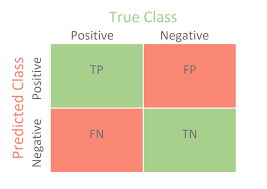

Fonte: [Towards Data Science](https://medium.com/m/global-identity?redirectUrl=https%3A%2F%2Ftowardsdatascience.com%2Fconfusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826)

In [ ]:
#criando os objetos dos modelos
random_forest_model = RandomForestClassifier()
lgbm_model = lgb.LGBMClassifier()
xgb_model = xgb.XGBClassifier()
bernoulli_model = BernoulliNB()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Seção 6: 

Rodando os modelos 1 vez e computando Accuracy Score, Area Under the Curve ROC, Precision, Recall, f1-socre, Support e visualizando a Area Under the Curve ROC.

####Aplicando modelos no data_corr

<IPython.core.display.Javascript object>

Accuracy Score = 0.75
AUC = 0.8009859885832901
Report:


precision    recall  f1-score  support
0              0.727273  0.851064  0.784314    47.00
1              0.787879  0.634146  0.702703    41.00
accuracy       0.750000  0.750000  0.750000     0.75
macro avg      0.757576  0.742605  0.743508    88.00
weighted avg   0.755510  0.750000  0.746290    88.00

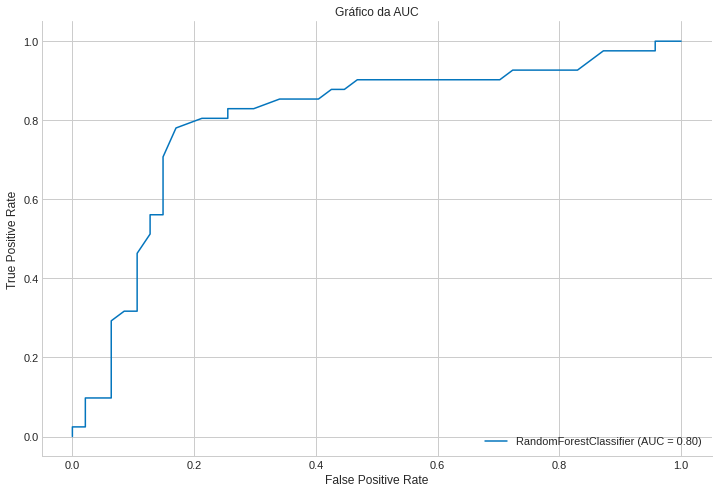

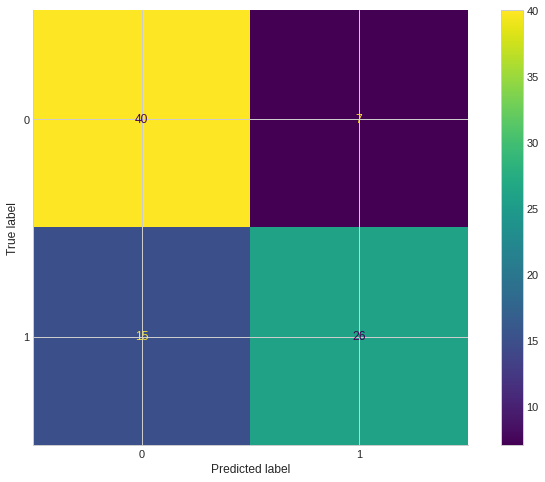

In [ ]:
#RandomForestClassifier para data_corr
run_models_com_plot(random_forest_model, data_corr)

<IPython.core.display.Javascript object>

Accuracy Score = 0.7272727272727273
AUC = 0.7483134405812143
Report:


precision    recall  f1-score    support
0              0.709091  0.829787  0.764706  47.000000
1              0.757576  0.609756  0.675676  41.000000
accuracy       0.727273  0.727273  0.727273   0.727273
macro avg      0.733333  0.719772  0.720191  88.000000
weighted avg   0.731680  0.727273  0.723226  88.000000

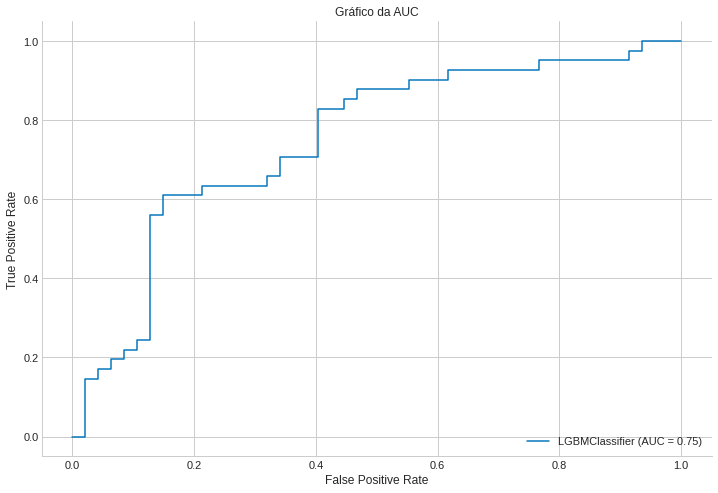

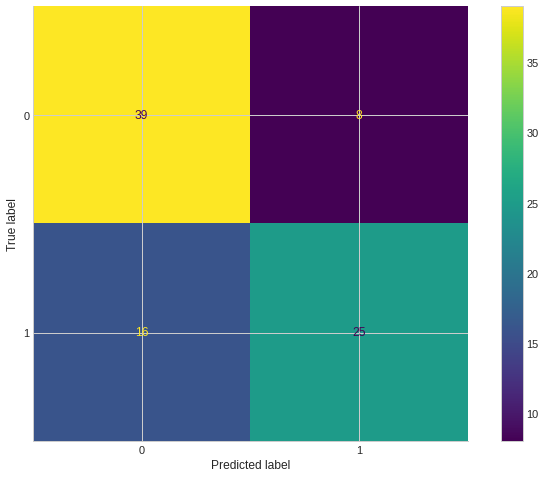

In [ ]:
#LGBM no dataset data_corr
run_models_com_plot(lgbm_model, data_corr)

<IPython.core.display.Javascript object>

Accuracy Score = 0.75
AUC = 0.7716658017644007
Report:


precision    recall  f1-score  support
0              0.727273  0.851064  0.784314    47.00
1              0.787879  0.634146  0.702703    41.00
accuracy       0.750000  0.750000  0.750000     0.75
macro avg      0.757576  0.742605  0.743508    88.00
weighted avg   0.755510  0.750000  0.746290    88.00

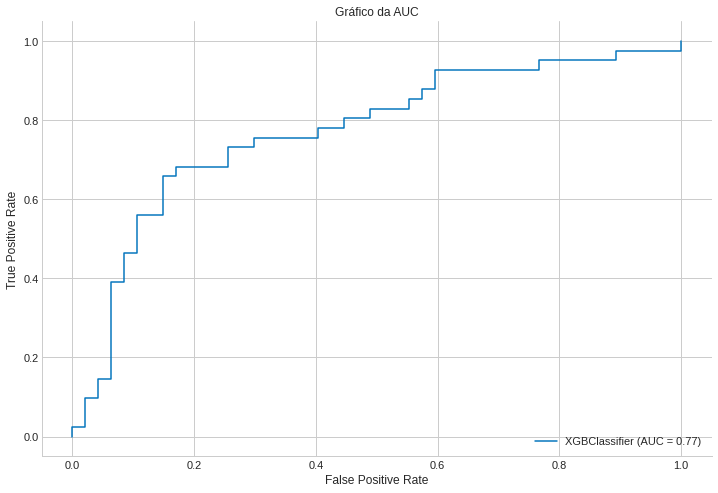

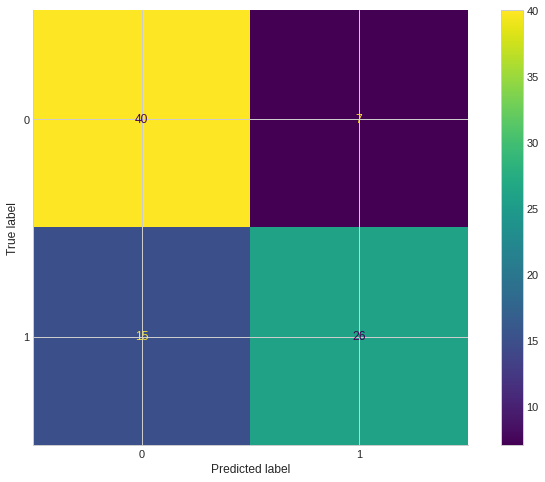

In [ ]:
#XGBmodel no dataframe data_corr
run_models_com_plot(xgb_model, data_corr)

<IPython.core.display.Javascript object>

Accuracy Score = 0.6136363636363636
AUC = 0.700570835495589
Report:


precision    recall  f1-score    support
0              0.622642  0.702128  0.660000  47.000000
1              0.600000  0.512195  0.552632  41.000000
accuracy       0.613636  0.613636  0.613636   0.613636
macro avg      0.611321  0.607161  0.606316  88.000000
weighted avg   0.612093  0.613636  0.609976  88.000000

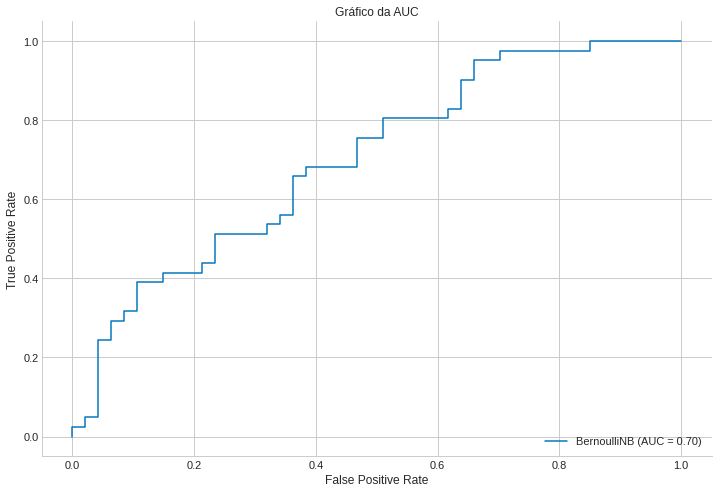

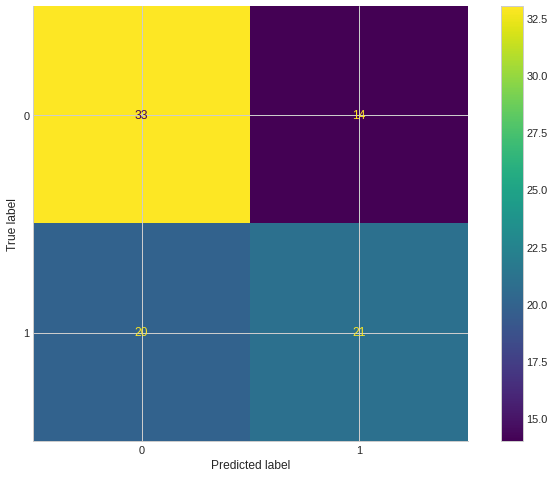

In [ ]:
#Bernoulli model no dataframe data_corr
run_models_com_plot(bernoulli_model, data_corr)

Em ordem com o encontrado no LazyPredict, **RandomForestClassifier** foi o modelo que melhor performou para o dataframe data_corr, com o **XGBClassifier** chegando bem próximo.

####Aplicando modelos no data_clean_binary_selected

<IPython.core.display.Javascript object>

Accuracy Score = 0.7159090909090909
AUC = 0.7729631551634665
Report:


precision    recall  f1-score    support
0              0.703704  0.808511  0.752475  47.000000
1              0.735294  0.609756  0.666667  41.000000
accuracy       0.715909  0.715909  0.715909   0.715909
macro avg      0.719499  0.709133  0.709571  88.000000
weighted avg   0.718422  0.715909  0.712496  88.000000

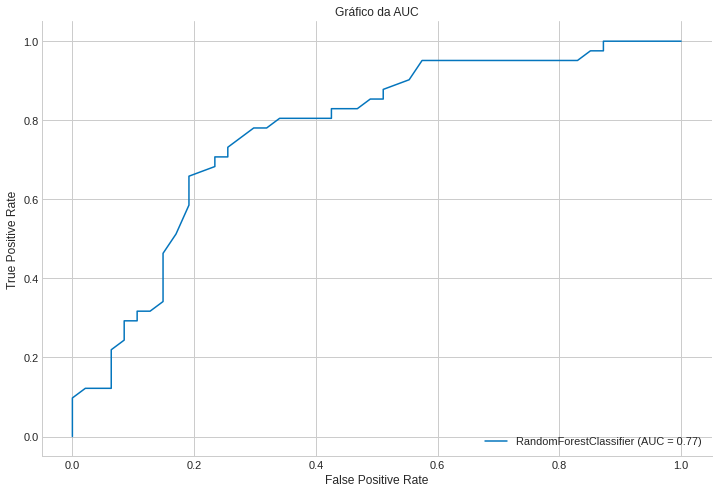

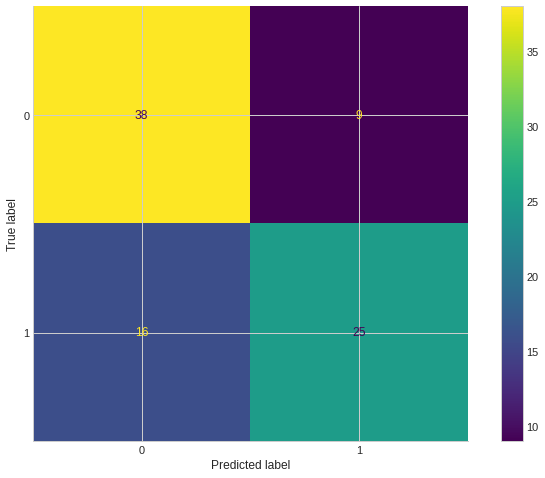

In [ ]:
#RandomForest no data_clean_binary
run_models_com_plot(random_forest_model, data_clean_binary_selected)

<IPython.core.display.Javascript object>

Accuracy Score = 0.6931818181818182
AUC = 0.7602490918526208
Report:


precision    recall  f1-score    support
0              0.685185  0.787234  0.732673  47.000000
1              0.705882  0.585366  0.640000  41.000000
accuracy       0.693182  0.693182  0.693182   0.693182
macro avg      0.695534  0.686300  0.686337  88.000000
weighted avg   0.694828  0.693182  0.689496  88.000000

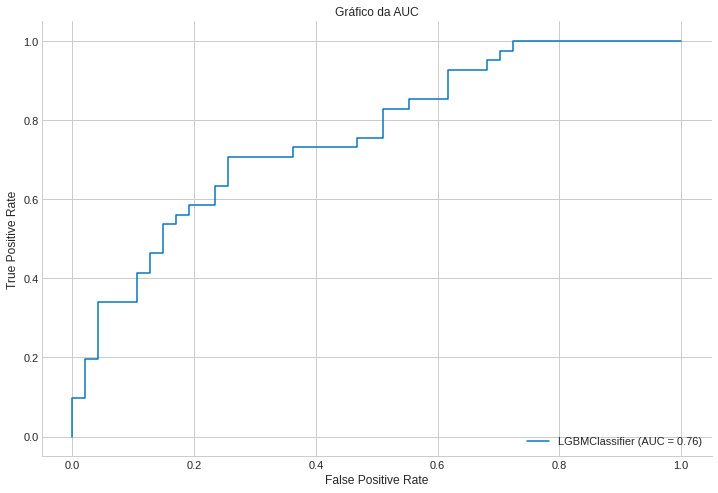

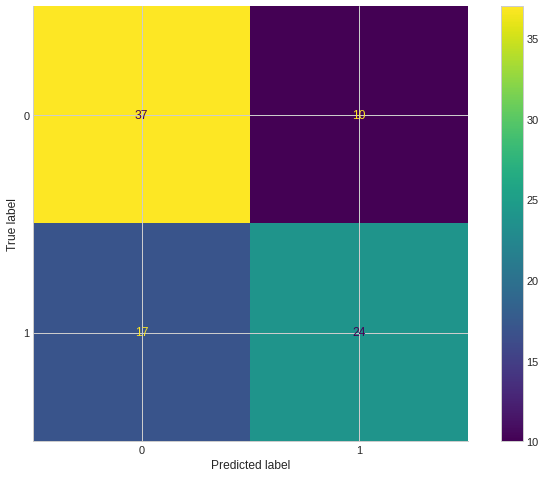

In [ ]:
#LGBM no data_clean_binary
run_models_com_plot(lgbm_model, data_clean_binary_selected)

<IPython.core.display.Javascript object>

Accuracy Score = 0.6818181818181818
AUC = 0.7529839128178516
Report:


precision    recall  f1-score    support
0              0.679245  0.765957  0.720000  47.000000
1              0.685714  0.585366  0.631579  41.000000
accuracy       0.681818  0.681818  0.681818   0.681818
macro avg      0.682480  0.675662  0.675789  88.000000
weighted avg   0.682259  0.681818  0.678804  88.000000

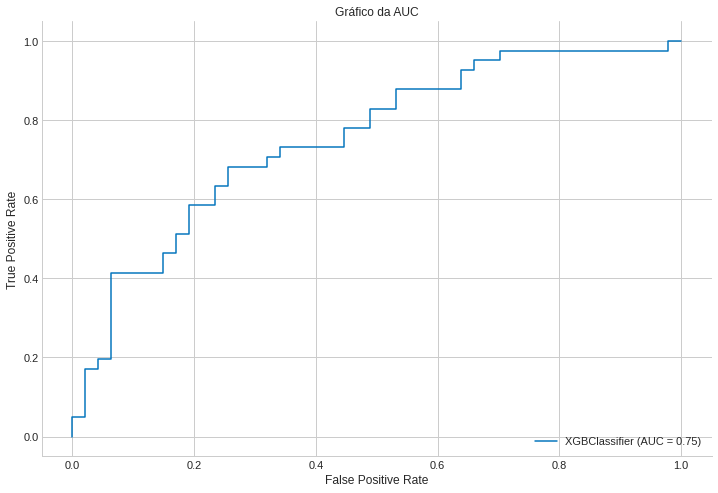

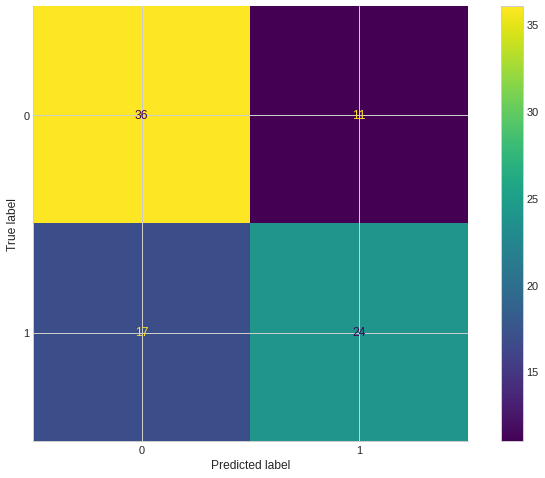

In [ ]:
#XGB no data_clean_binary
run_models_com_plot(xgb_model, data_clean_binary_selected)

<IPython.core.display.Javascript object>

Accuracy Score = 0.6363636363636364
AUC = 0.72184743124027
Report:


precision    recall  f1-score    support
0              0.641509  0.723404  0.680000  47.000000
1              0.628571  0.536585  0.578947  41.000000
accuracy       0.636364  0.636364  0.636364   0.636364
macro avg      0.635040  0.629995  0.629474  88.000000
weighted avg   0.635481  0.636364  0.632919  88.000000

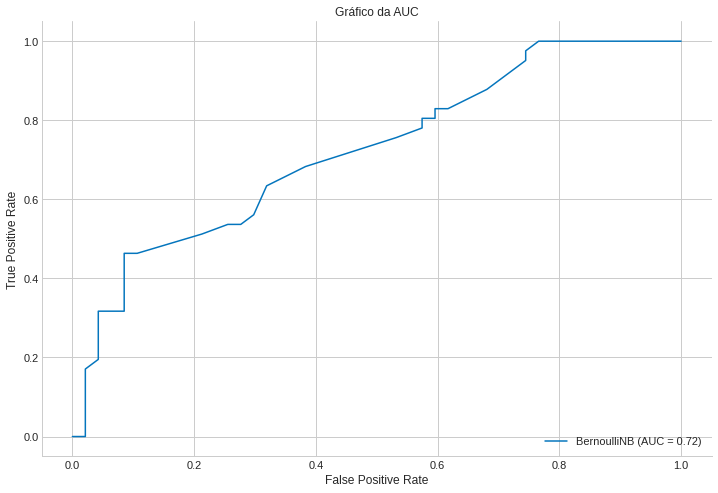

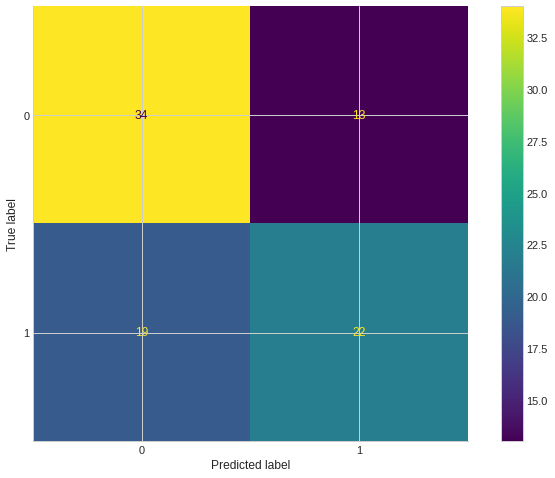

In [ ]:
#Bernoulli no data_clean_binary
run_models_com_plot(bernoulli_model, data_clean_binary_selected)

Para o dataframe data_clean_binary_selected com exceção do modelo BernoulliNB, todos os outros performaram muito próximos, com o RandomForestClassifier se sobressaindo novamente.

####Aplicando modelos no data_clean_class_selected

<IPython.core.display.Javascript object>

Accuracy Score = 0.7613636363636364
AUC = 0.8056564608199274
Report:


precision    recall  f1-score    support
0              0.770833  0.787234  0.778947  47.000000
1              0.750000  0.731707  0.740741  41.000000
accuracy       0.761364  0.761364  0.761364   0.761364
macro avg      0.760417  0.759471  0.759844  88.000000
weighted avg   0.761127  0.761364  0.761147  88.000000

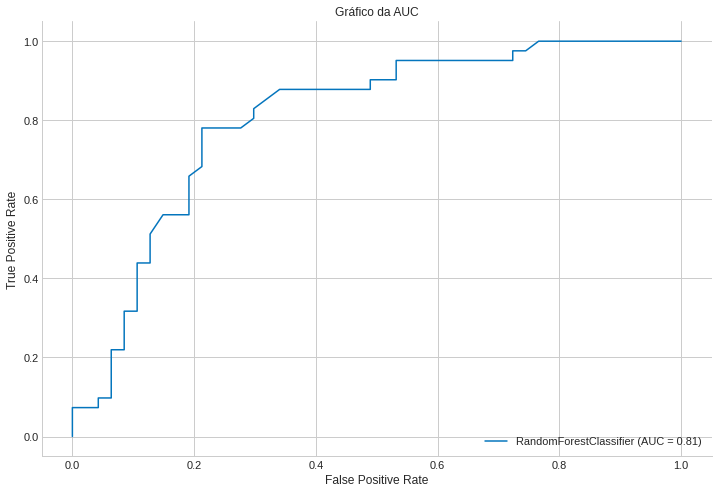

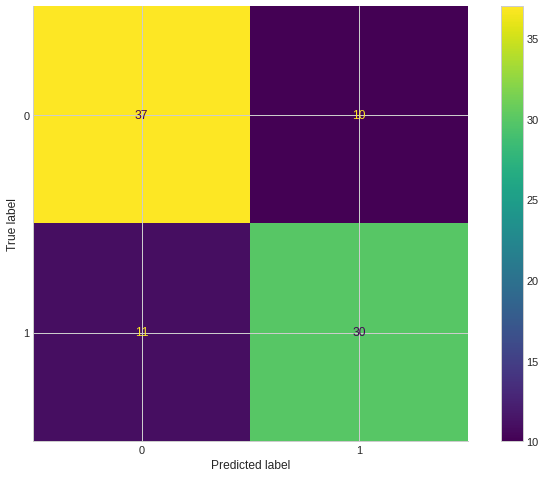

In [ ]:
#RandomForest no data_clean_class
run_models_com_plot(random_forest_model, data_clean_class_selected)

<IPython.core.display.Javascript object>

Accuracy Score = 0.6818181818181818
AUC = 0.7451997924234561
Report:


precision    recall  f1-score    support
0              0.672727  0.787234  0.725490  47.000000
1              0.696970  0.560976  0.621622  41.000000
accuracy       0.681818  0.681818  0.681818   0.681818
macro avg      0.684848  0.674105  0.673556  88.000000
weighted avg   0.684022  0.681818  0.677097  88.000000

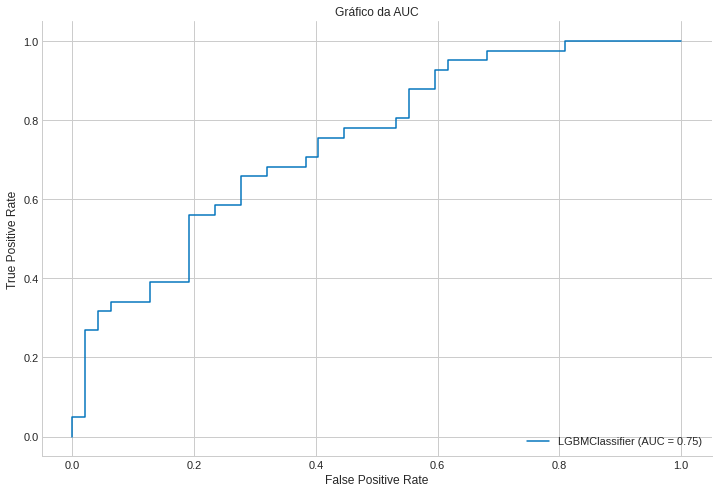

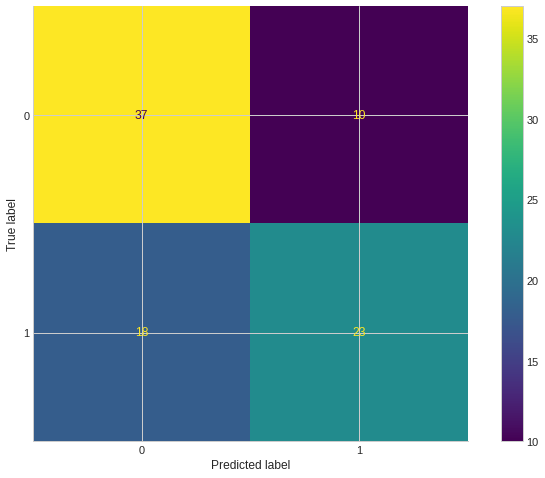

In [ ]:
#LGBM no data_clean_class
run_models_com_plot(lgbm_model, data_clean_class_selected)

<IPython.core.display.Javascript object>

Accuracy Score = 0.7159090909090909
AUC = 0.7887908666320705
Report:


precision    recall  f1-score    support
0              0.711538  0.787234  0.747475  47.000000
1              0.722222  0.634146  0.675325  41.000000
accuracy       0.715909  0.715909  0.715909   0.715909
macro avg      0.716880  0.710690  0.711400  88.000000
weighted avg   0.716516  0.715909  0.713859  88.000000

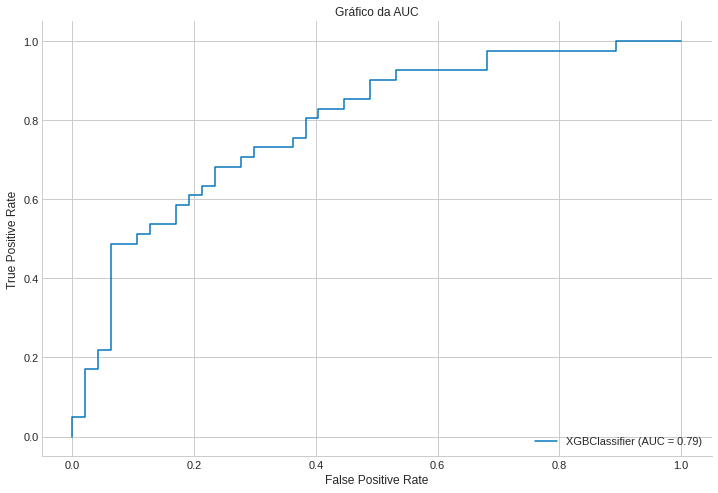

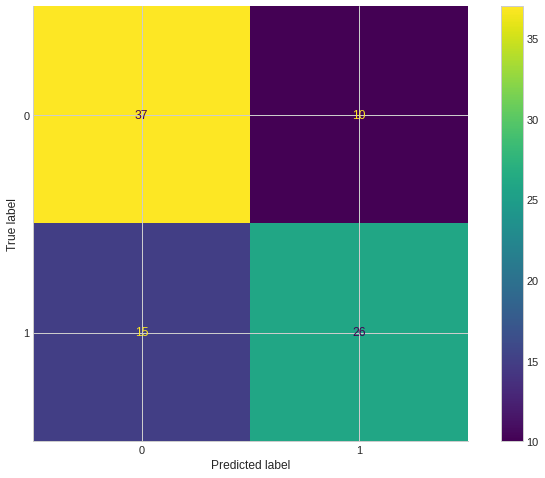

In [ ]:
#XGB no data_clean_class
run_models_com_plot(xgb_model, data_clean_class_selected)

<IPython.core.display.Javascript object>

Accuracy Score = 0.625
AUC = 0.7067981318111053
Report:


precision    recall  f1-score  support
0              0.634615  0.702128  0.666667   47.000
1              0.611111  0.536585  0.571429   41.000
accuracy       0.625000  0.625000  0.625000    0.625
macro avg      0.622863  0.619357  0.619048   88.000
weighted avg   0.623665  0.625000  0.622294   88.000

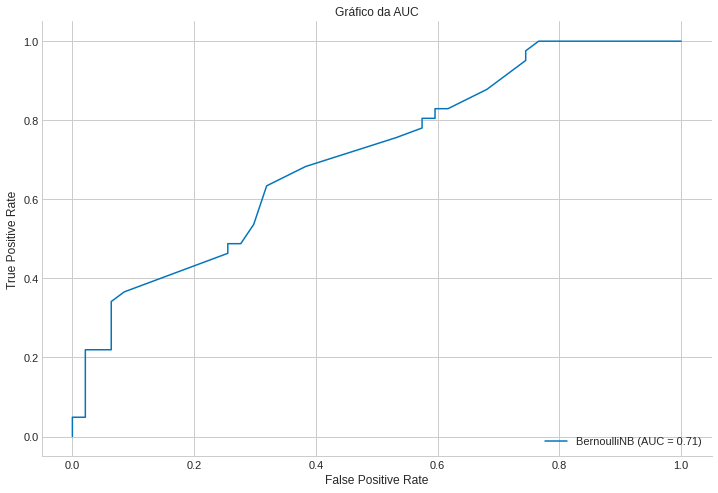

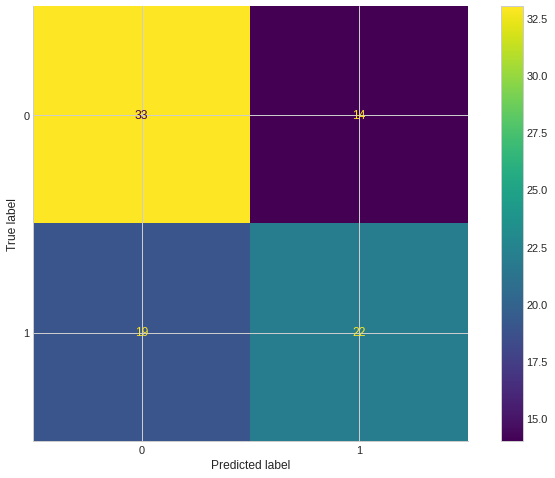

In [ ]:
#Bernoulli no data_clean_class
run_models_com_plot(bernoulli_model, data_clean_class_selected)

Finalmente, no dataset data_clean_class_selected novamente RandomForestClassifier se sobressaiu perante os outros modelos.

##Nossa conclusão destas aplicações:
Iremos seguir em frente com os modelos **RandomForestClassifier** e 
**XGBClassifier** que tiveram bom AUC, Recall e conseguiram diminuir o número Falsos Negativos na matriz de confusão. Pudemos perceber também que o dataframe data_clean_binary_selected performou muito abaixo dos outros, principalmente no Recall, por isso deixaremos esse dataframe por aqui e prosseguiremos apenas com o data_corr e o data_clean_class_selected.

#Seção 7: Observando o auc médio nos modelos

---
Apesar das boas performances dos modelos e de termos embaralhado os dados para aumentar a aleatoriedade, esta ainda pode se fazer presente e estar alterando nossos resultados, para isso iremos olhar mais uma vez para a Area Under the ROC Curver porém desta vez uma AUC média de várias rodadas no modelo.


In [ ]:
#RandomForest no data_corr
roda_n_modelos(random_forest_model, data_corr, 10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC médio: 0.7797093928386093
Intervalo 0.7020462163803034 - 0.8573725692969152
Recall médio: 0.6585365853658536


In [ ]:
#XGB no data_corr
roda_n_modelos(xgb_model, data_corr, 10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC médio: 0.788168137000519
Intervalo 0.7106030845479256 - 0.8657331894531124
Recall médio: 0.673170731707317


In [ ]:
#RandomForest no data_clean_class
roda_n_modelos(random_forest_model, data_clean_class_selected, 10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC médio: 0.8133627400103787
Intervalo 0.7369968381259315 - 0.8897286418948258
Recall médio: 0.7170731707317073


In [ ]:
#XGB no data_clean_class
roda_n_modelos(xgb_model, data_clean_class_selected, 10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

AUC médio: 0.8211728074727557
Intervalo 0.7546394250044526 - 0.8877061899410588
Recall médio: 0.7073170731707317


Rodando vários modelos e computando um AUC médio e um recall médio temos que o RandomForestClassifier no dataset data_clean_class_selected performou melhor conforme abaixo:

AUC médio: 0.8133627400103787

Intervalo 0.7369968381259315 - 0.8897286418948258

Recall médio: 0.7170731707317073

#Seção 8: Selecionando hiperparâmetros para os modelos

---





Nesta seção iremos realizar o processo de tunagem dos hiperparâmetros dos dois modelos. Para isso utilizaremos uma abordagem bayesiana de otimização que usa um processo gaussiano de regressão com o BayeSearchCV da biblioteca [scikit-optimizer](https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html#sphx-glr-auto-examples-bayesian-optimization-py). E compararemos o best_score e o best_params dos dois modelos e suas respectivas tunagens.

In [ ]:
#Definindo hiperparâmetros para otimizar nos modelos
modelos_a_treinar = [random_forest_model, xgb_model]

grid_parameters = [
                   { #RandomForest
                      'n_estimators':[100, 200, 400, 500,1000],
                      'max_depth':[10,15,20,25],
                      'max_samples':[0.7,0.75,0.8,0.85],
                      'max_features':[2,4,6,8,10]
                
                   },
                   { #XGB
                    'n_estimators': [100,400,700,1000,2000],
                    'learning_rate': [0.12],
                    'colsample_bytree': [0.7, 0.8],
                    'max_depth': [4,6,8,10,12,20],
                    'booster': ['gbtree', 'gblinear', 'dart'],
                    'reg_alpha': [1.1, 1.2],
                    'reg_lambda': [1.1, 1.2],
                    'subsample': [0.8, 0.9],
                    'num_parallel_tree': [1,3,5,10]
                    },
]

In [ ]:
np.random.seed(65841532)
shuffled_data_corr = data_corr.copy()
shuffled_data_corr = shuffled_data_corr.sample(frac=1).reset_index(drop=True)
x = shuffled_data_corr.drop(columns=['ICU'])
y = shuffled_data_corr['ICU']
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y)

models_performance = []
for i, model in enumerate(modelos_a_treinar):
  params = grid_parameters[i]
  results = tuna_hiperparametros(x_train, x_test, y_train, y_test, model, params)
  models_performance.append(results)
time.perf_counter()

<IPython.core.display.Javascript object>

7943.244564172

In [ ]:
for result in models_performance:
  print(f"Model: {type(result[0]).__name__}, ROC-AUC Score: {result[2]}, \n best_parameters: {result[3]}")

Model: RandomForestClassifier, ROC-AUC Score: 0.849507005708355, 
 best_parameters: OrderedDict([('max_depth', 10), ('max_features', 8), ('max_samples', 0.7), ('n_estimators', 200)])
Model: XGBClassifier, ROC-AUC Score: 0.8074727555786195, 
 best_parameters: OrderedDict([('booster', 'gbtree'), ('colsample_bytree', 0.8), ('learning_rate', 0.12), ('max_depth', 20), ('n_estimators', 100), ('num_parallel_tree', 1), ('reg_alpha', 1.1), ('reg_lambda', 1.1), ('subsample', 0.8)])


In [ ]:
np.random.seed(796851)
shuffled_data_class = data_clean_class_selected.copy()
shuffled_data_class = shuffled_data_class.sample(frac=1).reset_index(drop=True)
x_c = shuffled_data_class.drop(columns=['ICU'])
y_c = shuffled_data_class['ICU']
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x_c,y_c, stratify=y_c)

models_performance_c = []
for i, model in enumerate(modelos_a_treinar):
  params = grid_parameters[i]
  results = tuna_hiperparametros(x_train_c, x_test_c, y_train_c, y_test_c, model, params)
  models_performance_c.append(results)
time.perf_counter()

<IPython.core.display.Javascript object>

13692.347770154

In [ ]:
for result_c in models_performance_c:
  print(f"Model: {type(result_c[0]).__name__}, Score: {result_c[2]}, best_parameters: {result_c[3]}")

Model: RandomForestClassifier, Score: 0.7950181629475869, best_parameters: OrderedDict([('max_depth', 10), ('max_features', 10), ('max_samples', 0.75), ('n_estimators', 200)])
Model: XGBClassifier, Score: 0.7861961598339388, best_parameters: OrderedDict([('booster', 'dart'), ('colsample_bytree', 0.7335241147999627), ('learning_rate', 0.12), ('max_depth', 4), ('n_estimators', 400), ('num_parallel_tree', 10), ('reg_alpha', 1.1036039607942385), ('reg_lambda', 1.1285068579225144), ('subsample', 0.8114426491381332)])


In [ ]:
random_forest_tunado = RandomForestClassifier(max_depth=10, max_features=8, max_samples=0.7, n_estimators=200)
xgb_classifier_tunado = xgb.XGBClassifier(booster='gbtree', colsample_bytree=0.8, learning_rate=0.12, max_depth=20, n_estimators=100,
                                          num_parallel_tree=1, reg_alpha=1.1, reg_lamba=1.1, subsample=0.8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Seção 9: Construindo um Stack and Embedded Model

---

Após essa tunagem de parâmetros podemos ver que as performances nos dois dataframes ficam próximas, com destaque para o dataframe data_corr e a RandomForestClassifier com 0.84 de ROC AUC Score.

Abaixo registramos os parâmetros para tunagem em cada modelo e agora temos uma primeira conclusão: O benchmark de classificação foi batido com o dataframe data_corr e o RandomForestClassifier.

No entanto, num movimento de melhorar ainda mais nosso modelo, iremos setar essa combinação como novo benchmark e aplicaremos um método chamado "Stack and Embedding Machine Learning" que consiste em treinar vários modelos em *layers* e depois aplicar um meta-learner final combinando todos os aprendizados de forma a conseguir melhores resultados.

Ao mesmo tempo que será o benchmark para o Stack and Embedding, o RandomForest tunado será nosso meta-learner por ter alcançado a melhor performance e capacidade de generalização.

O processo de Stack and Embedding será como na imagem abaixo:

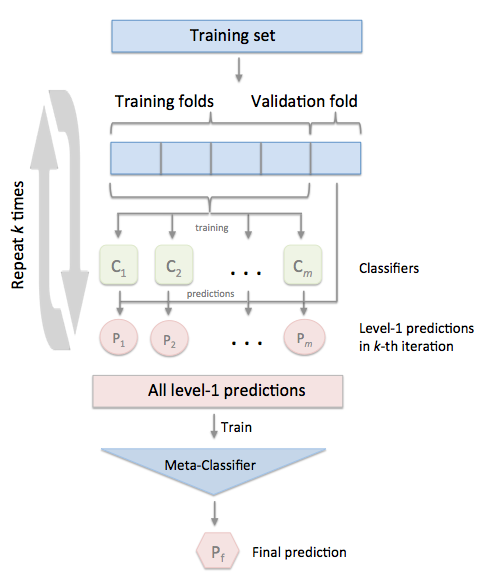

Referência sobre Stack and Embedding ML [aqui](https://developer.ibm.com/articles/stack-machine-learning-models-get-better-results/).

In [ ]:
#selecionando e nomeando os algoritmos
xgb_model = xgb.XGBClassifier(booster='gbtree', colsample_bytree=0.8, learning_rate=0.12, max_depth=20, n_estimators=100,
                                          num_parallel_tree=1, reg_alpha=1.1, reg_lamba=1.1, subsample=0.8)
lgbm_model = lgb.LGBMClassifier()
random_forest_model = RandomForestClassifier(max_depth=10, max_features=8, max_samples=0.7, n_estimators=200)
svc_model = svm.SVC()
nu_svc_model = svm.NuSVC()
nc_model = NearestCentroid()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Construindo o stackingCV
np.random.seed(8941563)
shuffled_data_corr = data_corr.copy()
shuffled_data_corr = shuffled_data_corr.sample(frac=1).reset_index(drop=True)
x = shuffled_data_corr.drop(columns=['ICU'])
y = shuffled_data_corr['ICU']
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y)
#Como há um bug entre as bibliotecas mlxtend e a xgb por esta última renomear as colunas para 'f{i}' for i in x_train.columns
#teremos qeu renomear as colunas de x_test para os mesmos nomes
for i, col in enumerate(x_test.columns):
  x_test[f'f{i}'] = x_test[col]
x_test = x_test.drop(x_test.columns[0:103], axis=1)


stacked_model = StackingCVClassifier(classifiers=(xgb_model, lgbm_model, svc_model, nu_svc_model, nc_model),
                            meta_classifier=random_forest_model, cv=10,
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=True,
                            stratify=True)
stacked_model.fit(x_train.values, y_train.values)
y_pred = stacked_model.predict(x_test)
y_pred_proba = stacked_model.predict_proba(x_test)
auc_score_sclf = roc_auc_score(y_test, y_pred_proba[:,1])
recall_score_sclf = recall_score(y_test, y_pred)
print(f'O ROC AUC Score do Stacked Model é: {auc_score_sclf} \n E o recall score é: {recall_score_sclf}')

<IPython.core.display.Javascript object>

O ROC AUC Score do Stacked Model é: 0.8463933575505969 
 E o recall score é: 0.8292682926829268


In [ ]:
np.random.seed(694165)
shuffled_data_corr = data_corr.copy()
shuffled_data_corr = shuffled_data_corr.sample(frac=1).reset_index(drop=True)
x = shuffled_data_corr.drop(columns=['ICU'])
y = shuffled_data_corr['ICU']
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y)

random_forest_model.fit(x_train, y_train)
pred = random_forest_model.predict(x_test)
pred_proba = random_forest_model.predict_proba(x_test)
recall_score_rfc = recall_score(y_test, pred)
print(f'ROC AUC Score: {roc_auc_score(y_test, pred_proba[:,1])} \n recall: {recall_score_rfc}')

<IPython.core.display.Javascript object>

ROC AUC Score: 0.8604047742605085 
 recall: 0.7073170731707317


In [ ]:
roda_modelo_cv(random_forest_model, data_corr, 5, 10)

AUC Médio 0.8025766062114745 Intervalo 0.691162604786977 - 0.9139906076359721


##Conclusões sobre Stack and Embedding e escolha final de modelo

---

Após rodar o stacked model, rodamos novamente o RandomForestClassifier tunado juntamente com uma cross-validation dele e apesar de no ROC AUC Score este sozinho pontuar mais do que o Stacked Model entendemos que para este problema especificamente alcançar também um Recall maior é muito importante como já explicamos neste trabalho.

Portanto, nossa escolha final para este projeto é o **StackedClassifier com uma performance de AUC: 0.84 e Recall de 0.82.**

##Salvando o modelo final

---
Nesta seção final salvaremos nosso modelo para um arquivo permitindo que ele vá para produção e que seja utilizado em outros lugares e que possamos rodá-lo novamente sem todo o esforço de treinamento e construção que fizemos neste notebook.

Em seguida teremos uma retomada do que foi feito até aqui junto de uma conclusão final.


In [ ]:
#salvando o modelo
joblib.dump(stacked_model, 'uci_stacked_model_clf_jlib')

['uci_stacked_model_clf_jlib']

#Seção 10: Conclusões finais do projeto

---
Este projeto começou com a provocação de encontrarmos se era possível construir um algoritmo de Machine Learning que previsse a entrada na UTI de pacientes com COVID-19 visando auxiliar e agilizar a tomada de decisão dos gestores responsáveis.

Utilizando um dataset do hospital Sírio-libanês sobre com dados de pacientes desse perfil, exploramos os dados através da Análise Exploratória de Dados e encontramos achados importantes e que confirmam outras evidências disponíveis de que homens vão mais para a UTI por complicações da doença, pessoas mais velhas também são mais acometidas e necessitam desse atendimento e mesmo a correlação entre alguns grupos de doenças e a ida ou não para a UTI.

Em seguida realizamos um processo de Feature Selection em que tentamos extrair as principais características únicas do dataset e que tivessem boa correlação com o feature alvo.

Após esse processo nos encontramos com três dataframes para os quais construímos benchmarks individuais de modelos de classificação com o DummyClassifier. Depois aplicamos uma primeira seleção de algoritmos com a biblioteca Lazypredict, depois a partir das melhores performances nessa primeira rolagem, selecionamos os melhores na rolagem por Dataframe e passamos a aplicações mais profundas deles, observando seu desempenho com as pontuações de ROC AUC Score, Recall e na matriz de confusão.

Nos deparamos com um bom desempenho para o RandomForestClassifier e para o XGBClassifier, com estes passamos à seção de tunagem de hiperparâmetros, em que a partir de uma abordagem bayesiana selecionamos os parâmetros que nos permitissem elevar a performances dos modelos. 

**Nessa conseguimos uma performance de ROC AUC Score de 0.86 com o RandomForestClassifier, o elevando ao melhor modelo.**

No entanto, num esforço de melhorar ainda mais e elevar o recall do modelo, realizamos um **processo de Stack and Embedding ML rodando 5 modelos com o RandomForestClassifier tunado como meta-learner.**

E**ste modelo final apesar de um ROC AUC Score levemente menor, elevou bastante a performance de Recall, o fazendo ser nossa escolha final para o projeto.** Além também não é um modelo lento de se rodar, que garante a rapidez que uma tomada de decisão desse tamanho em que vidas podem ser perdidas exige.

Todos os arquivos utilizados nesse projeto e o arquivo contendo o modelo treinado podem ser encontrados no repositório do projeto.
